# Organic Livestock - Analysis and Prediction

The data required for this project is obtained from the European Union Website: https://ec.europa.eu/eurostat/databrowser/view/ORG_LSTSPEC/default/table?lang=en&category=agr.org.
The data collection was based on the Commission Regulation (EC) No 889/2008 implementing the Council Regulation (EC) No 834/2007 on organic production and labelling of organic products. This data was collected as summary tables to display an overview of the uptake of organic farming within the European Union, the United Kingdom, Iceland, and Norway. Switzerland and some candidate countries (Montenegro, North Macedonia, Serbia, and Turkey) also provide data on a voluntary basis. 
In some cases, there were zero counts shown up, this does not really mean there is not any livestock in the country for that year, but it means the numbers are not provided by the member country. 
The data is available as an open data in the European Union website, confidentiality of the data is described as a column marked as ‘c’, this is not applicable in the data selected for organic livestock analysis.
Metadata for the acquired data is available below:
https://ec.europa.eu/eurostat/cache/metadata/en/org_esms.htm
The data is available in a data browser, it is downloaded and used for analysis.


In [1]:
#Import libraries

#Mathematical and data manipulation library
import pandas as pd
import numpy as np

#Statistics Library
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

#Import Libraries for ML
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE 
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers

#Visualisation
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import Layout
import matplotlib.pyplot as plt 
import seaborn as sns


In [2]:
#Read the livestock dataset using pandas(Source: https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/org_lstspec.tsv.gz)
#Used encoding to latin to read latin-1 (since some of the country name had latin characters)
#dflsraw is a dataframe to hold raw livestock
dflsraw=pd.read_csv('organic_livestock.csv',encoding='latin-1')

In [3]:
#Top 5 rows of the dataset
dflsraw.head()

TIME                                                GEO  \
0  2012  European Union (EU6-1958, EU9-1973, EU10-1981,...   
1  2012  European Union (EU6-1958, EU9-1973, EU10-1981,...   
2  2012  European Union (EU6-1958, EU9-1973, EU10-1981,...   
3  2012  European Union (EU6-1958, EU9-1973, EU10-1981,...   
4  2012  European Union (EU6-1958, EU9-1973, EU10-1981,...   

                        ANIMALS           UNIT Value Flag and Footnotes  \
0                   Live horses         Number     :                NaN   
1                   Live horses  Head (animal)     :                NaN   
2           Live bovine animals         Number     :                NaN   
3           Live bovine animals  Head (animal)     :                NaN   
4  Bovine animals for slaughter         Number     :                NaN   

   Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  
0         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN  
2         NaN         NaN         NaN         NaN  
3         NaN         NaN         NaN         NaN  
4         NaN         NaN         NaN         NaN

We will first do a data cleanup.
1) There are two units Number and Head ,we will keep one UNIT and base our analysis on this (Head).                         
2) Five fields with all Null Values, this should be removed from the dataset.                                               
3) Blank Values are denoted by :, we will remove them appropriate based on the amount of such bad data.                     
4) There are many columns which doesnt have any analytical significance and has NULL values, we can delete them from the  dataset  

In [4]:
# Keeping only UNIT=Head(animal).
dflsraw=dflsraw.loc[dflsraw['UNIT']=='Head (animal)']

In [5]:
#Selecting only the required fields for our analysis
dflsraw=dflsraw[['TIME','GEO','ANIMALS','Value']]
dflsraw.columns = ['YEAR','COUNTRY','ANIMALS','Counts']

In [6]:
# Remove the comma in Value field 
dflsraw['Counts']=dflsraw['Counts'].str.replace(',','')

#Replace ':' with 99999(dummy value), this is because we want to convert this field as an integer.
dflsraw['Counts']=dflsraw['Counts'].replace(':',99999)

In [7]:
#Converting the datatypes to logical ones according to the data
dflsraw['Counts']=dflsraw['Counts'].astype(int)
dflsraw['YEAR']=dflsraw['YEAR'].astype(object)


In [8]:
#Replace the Null value with NaN using numpy, idea is to handle the NaN in the next steps
dflsraw['Counts']=dflsraw['Counts'].replace(99999,np.NaN)

In [9]:
#Get the description of the dataframe to identify the NULL values
dflsraw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9120 entries, 1 to 18239
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YEAR     9120 non-null   object 
 1   COUNTRY  9120 non-null   object 
 2   ANIMALS  9120 non-null   object 
 3   Counts   5139 non-null   float64
dtypes: float64(1), object(3)
memory usage: 356.2+ KB


In [10]:
#Checking for 2021
dflsraw.loc[dflsraw['YEAR']==2021].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912 entries, 16417 to 18239
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YEAR     912 non-null    object 
 1   COUNTRY  912 non-null    object 
 2   ANIMALS  912 non-null    object 
 3   Counts   127 non-null    float64
dtypes: float64(1), object(3)
memory usage: 35.6+ KB


Since we now know the data for 2021 is not complete, it will lead to incorrect predictions and statistics, considering data until 2020

In [11]:
#Fetch records with YEAR <2021 for the analysis
dflsraw=dflsraw.loc[dflsraw['YEAR']<2021]

In [12]:
# Let us view the unique value of the country
dflsraw['COUNTRY'].unique()

array(['European Union (EU6-1958, EU9-1973, EU10-1981, EU12-1986, EU15-1995, EU25-2004, EU27-2007, EU28-2013, EU27-2020)',
       'European Union - 27 countries (from 2020)',
       'European Union - 28 countries (2013-2020)', 'Belgium', 'Bulgaria',
       'Czechia', 'Denmark',
       'Germany (until 1990 former territory of the FRG)', 'Estonia',
       'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy',
       'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta',
       'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania',
       'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'Iceland', 'Norway',
       'Switzerland', 'United Kingdom', 'Montenegro', 'North Macedonia',
       'Serbia', 'Türkiye'], dtype=object)

The task here is to compare the different regions on the EU, we donot need the overall igure, also when a eyeball check 
is done in the original worksheet the data in the excel for European Union is not complete, droping these rows from 
#the dataframe

In [13]:
#Removing the European Union records from the dataframe

#I could have used a wild card replace and removed EU, but just tried out by using the replace function
dflsraw['COUNTRY']=dflsraw['COUNTRY'].str.replace('European Union \(EU6-1958, EU9-1973, EU10-1981, EU12-1986, EU15-1995, EU25-2004, EU27-2007, EU28-2013, EU27-2020\)','European Union')
dflsraw['COUNTRY']=dflsraw['COUNTRY'].str.replace('European Union - 27 countries \(from 2020\)','European Union')
dflsraw['COUNTRY']=dflsraw['COUNTRY'].str.replace('European Union - 28 countries \(2013-2020\)','European Union')


index = dflsraw[dflsraw['COUNTRY'] == 'European Union'].index
dflsraw.drop(index, inplace=True)
#Resetting the index 
dflsraw.reset_index()
dflsraw.head()

YEAR  COUNTRY                       ANIMALS   Counts
145  2012  Belgium                   Live horses      NaN
147  2012  Belgium           Live bovine animals  72487.0
149  2012  Belgium  Bovine animals for slaughter      NaN
151  2012  Belgium                    Dairy cows  13049.0
153  2012  Belgium          Other bovine animals      NaN

In [14]:
#UK is not part of the EU, hence removing UK from the dataset.

dflsraw=dflsraw.loc[dflsraw['COUNTRY']!='United Kingdom']

In [15]:
#Display unique country
dflsraw['COUNTRY'].unique()

array(['Belgium', 'Bulgaria', 'Czechia', 'Denmark',
       'Germany (until 1990 former territory of the FRG)', 'Estonia',
       'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy',
       'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta',
       'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania',
       'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'Iceland', 'Norway',
       'Switzerland', 'Montenegro', 'North Macedonia', 'Serbia',
       'Türkiye'], dtype=object)

We now have the required country names for our analysis

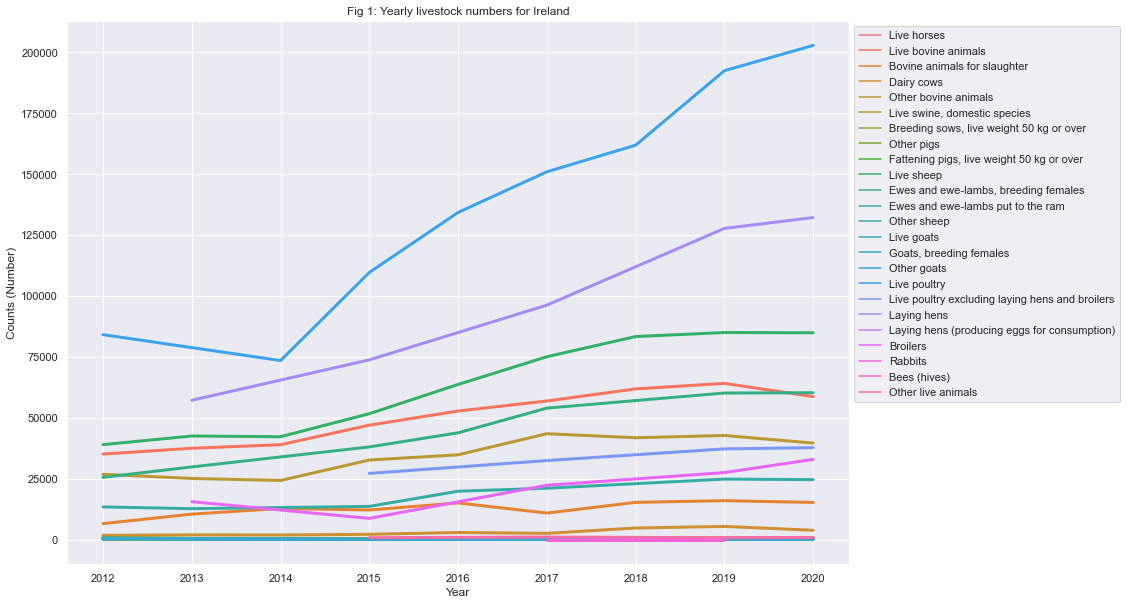

In [16]:
#Plot showing Yearly live stock for Ireland

sns.set_style('darkgrid') #usage of seaborn library set the style
sns.set(rc={'figure.figsize':(14,10)}) #usage of seaborn library set the figure size
sns.color_palette("tab10")#usage of seaborn library set the color palette
ax = sns.lineplot(data=dflsraw.loc[dflsraw['COUNTRY']=='Ireland'], x ='YEAR', y = 'Counts',
                  hue='ANIMALS', lw=3) # Draw the plot

plt.legend(bbox_to_anchor=(1, 1)) # Set the legends 
plt.ylabel('Counts (Number)') # Y label
plt.xlabel('Year') # X label
plt.title('Fig 1: Yearly livestock numbers for Ireland') # Set the title
plt.show() # Display the plot

In [17]:
dflsrawagg=dflsraw.loc[dflsraw['COUNTRY']=='Ireland'].groupby(['ANIMALS']).mean()
dflsrawagg

Counts
ANIMALS                                                       
Bees (hives)                                               NaN
Bovine animals for slaughter                      12703.222222
Breeding sows, live weight 50 kg or over             94.222222
Broilers                                          21388.200000
Dairy cows                                         3022.222222
Ewes and ewe-lambs put to the ram                          NaN
Ewes and ewe-lambs, breeding females              44501.857143
Fattening pigs, live weight 50 kg or over           294.444444
Goats, breeding females                             144.833333
Laying hens                                       97372.800000
Laying hens (producing eggs for consumption)               NaN
Live bovine animals                               50291.222222
Live goats                                          255.777778
Live horses                                         414.000000
Live poultry                                     138648.500000
Live poultry excluding laying hens and broilers   33628.750000
Live sheep                                        63008.111111
Live swine, domestic species                        593.888889
Other bovine animals                              34565.777778
Other goats                                         139.500000
Other live animals                                  859.250000
Other pigs                                          205.222222
Other sheep                                       18579.571429
Rabbits                                               0.000000

Based on the above two visualisations, Live Poultry counts are the highest for Ireland 

Next step is to convert the animal types to columns, so that each row will now consists of the individual animal births for the year and country.

In [18]:
# Using pivot function, specify the index, columns, and the values. The purpose here is to replace the NaN values, logically for each country and animal type
dflspivot= dflsraw.pivot (index=['COUNTRY','YEAR'],columns='ANIMALS',values='Counts').reset_index()


In [19]:
# just want to see the difference beween the two dataframes befoire and after pivot
#Before
dflsraw.head()

YEAR  COUNTRY                       ANIMALS   Counts
145  2012  Belgium                   Live horses      NaN
147  2012  Belgium           Live bovine animals  72487.0
149  2012  Belgium  Bovine animals for slaughter      NaN
151  2012  Belgium                    Dairy cows  13049.0
153  2012  Belgium          Other bovine animals      NaN

In [20]:
# just want to see the difference beween the two dataframes befoire and after pivot
#After
dflspivot.head()

ANIMALS  COUNTRY  YEAR  Bees (hives)  Bovine animals for slaughter  \
0        Austria  2012           NaN                           NaN   
1        Austria  2013           NaN                           NaN   
2        Austria  2014           NaN                        4397.0   
3        Austria  2015           NaN                       25773.0   
4        Austria  2016           NaN                       32988.0   

ANIMALS  Breeding sows, live weight 50 kg or over  Broilers  Dairy cows  \
0                                          4370.0  339089.0     94591.0   
1                                          3579.0       NaN     95873.0   
2                                          5444.0  457868.0     96829.0   
3                                          5743.0  597579.0     95361.0   
4                                          5020.0  980699.0    106735.0   

ANIMALS  Ewes and ewe-lambs put to the ram  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

ANIMALS  Ewes and ewe-lambs, breeding females  \
0                                         NaN   
1                                     61346.0   
2                                     48495.0   
3                                     51799.0   
4                                     59066.0   

ANIMALS  Fattening pigs, live weight 50 kg or over  ...  Live poultry  \
0                                          30385.0  ...     1470854.0   
1                                          25742.0  ...     1403597.0   
2                                          30046.0  ...     1484362.0   
3                                          34717.0  ...     1747183.0   
4                                          28084.0  ...     2282384.0   

ANIMALS  Live poultry excluding laying hens and broilers  Live sheep  \
0                                                    NaN     99752.0   
1                                                    NaN    100238.0   
2                                               401272.0     99286.0   
3                                               408979.0    102601.0   
4                                               470208.0    112182.0   

ANIMALS  Live swine, domestic species  Other bovine animals  Other goats  \
0                             69475.0                   NaN          NaN   
1                             70935.0                   NaN          NaN   
2                             68031.0              275421.0      17138.0   
3                             78246.0              145102.0      16610.0   
4                             62672.0              264925.0      19163.0   

ANIMALS  Other live animals  Other pigs  Other sheep  Rabbits  
0                       NaN         NaN          NaN   3463.0  
1                       NaN         NaN          NaN   1400.0  
2                       NaN     32541.0      50791.0   3250.0  
3                    8109.0     37786.0      50802.0   3323.0  
4                    9307.0     29568.0      53116.0   4121.0  

[5 rows x 26 columns]

In [21]:
#Comparing the mean and other statistical value for the sample three animal types

dflspivot[['Live poultry','Live poultry excluding laying hens and broilers','Live sheep']].describe()

ANIMALS  Live poultry  Live poultry excluding laying hens and broilers  \
count    2.740000e+02                                     1.860000e+02   
mean     1.251981e+06                                     9.332402e+04   
std      3.182328e+06                                     2.336085e+05   
min      0.000000e+00                                     0.000000e+00   
25%      1.920625e+04                                     1.162500e+02   
50%      1.056160e+05                                     2.133000e+03   
75%      1.080051e+06                                     3.759350e+04   
max      2.384456e+07                                     1.492674e+06   

ANIMALS    Live sheep  
count    2.870000e+02  
mean     1.292708e+05  
std      2.332917e+05  
min      0.000000e+00  
25%      1.511050e+04  
50%      3.636600e+04  
75%      9.999500e+04  
max      1.440721e+06

In [22]:
# Trying to see the NULL values in each of the column now
dflspivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 26 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   COUNTRY                                          306 non-null    object 
 1   YEAR                                             306 non-null    int64  
 2   Bees (hives)                                     0 non-null      float64
 3   Bovine animals for slaughter                     239 non-null    float64
 4   Breeding sows, live weight 50 kg or over         269 non-null    float64
 5   Broilers                                         199 non-null    float64
 6   Dairy cows                                       261 non-null    float64
 7   Ewes and ewe-lambs put to the ram                0 non-null      float64
 8   Ewes and ewe-lambs, breeding females             177 non-null    float64
 9   Fattening pigs, live weight 50 k

We see that Bees (hives) , Ewes and ewe-lambs put to the ram , Laying hens (producing eggs for consumption)  has 0 counts, hence can be removed from analysis.

In [23]:
#We see that Bees (hives) , Ewes and ewe-lambs put to the ram , Laying hens (producing eggs for consumption) has 0 counts, hence can be removed from analysis.

dflspivot.drop(['Bees (hives)','Ewes and ewe-lambs put to the ram','Laying hens (producing eggs for consumption)'],axis=1,inplace=True)

In the next step, we will clean up the NaN with the ffill and bfill function. ffill will fill the NA fields based on the value in previous row for the column, if the first field itself is not available it will fill then next fill using bfill

In [24]:
# we will clean up the NaN with the ffill and bfill function. ffill will fill the NA fields based on the value in previous row for the column, if the first field itself is not available it will fill then next fill using bfill

dflspivot.sort_values(by='YEAR', inplace=True) #Sorting since the correct values are backfilled or frontfilled

colnames=dflspivot.columns.values
for i in colnames: #Iterating all the columns in the dataframe
    dflspivot[i] = dflspivot.groupby(['COUNTRY'])[i].ffill()
    dflspivot[i] = dflspivot.groupby(['COUNTRY'])[i].bfill()

In [25]:
#Checking the Null values again

dflspivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 0 to 305
Data columns (total 23 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   COUNTRY                                          306 non-null    object 
 1   YEAR                                             306 non-null    int64  
 2   Bovine animals for slaughter                     261 non-null    float64
 3   Breeding sows, live weight 50 kg or over         297 non-null    float64
 4   Broilers                                         288 non-null    float64
 5   Dairy cows                                       279 non-null    float64
 6   Ewes and ewe-lambs, breeding females             243 non-null    float64
 7   Fattening pigs, live weight 50 kg or over        288 non-null    float64
 8   Goats, breeding females                          243 non-null    float64
 9   Laying hens                     

In [26]:
#There are more NULL values, these are the cases where for a country for all the years there is nothing submitted, we will mark such NaN as 0.

dflspivot.sort_values(by='YEAR', inplace=True) 

colnames=dflspivot.columns.values
for i in colnames:
    dflspivot[i] = dflspivot[i].replace(np.nan, 0)


In [27]:
# Display and check NULL values again
dflspivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 0 to 305
Data columns (total 23 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   COUNTRY                                          306 non-null    object 
 1   YEAR                                             306 non-null    int64  
 2   Bovine animals for slaughter                     306 non-null    float64
 3   Breeding sows, live weight 50 kg or over         306 non-null    float64
 4   Broilers                                         306 non-null    float64
 5   Dairy cows                                       306 non-null    float64
 6   Ewes and ewe-lambs, breeding females             306 non-null    float64
 7   Fattening pigs, live weight 50 kg or over        306 non-null    float64
 8   Goats, breeding females                          306 non-null    float64
 9   Laying hens                     

In [28]:

dflspivot['YEAR']=dflspivot['YEAR'].astype(object)


# Descriptive Statistics

We have now done basic data clean up, we should now proceed with the statistical analysis. First step we will pivot the data to the structure we need, idea is to find the stastics of livestock in each year.

In [29]:
# Store the EU live poultry aggregate to a variable a, change the format to save as non-exponential format

lpeu=dflspivot[['Live poultry']].describe().apply(lambda s: s.apply('{0:.5f}'.format)).reset_index()

#Store the Live poultry aggregate for Ireland in another variable

lpi=dflspivot[['Live poultry']].loc[dflspivot['COUNTRY']=='Ireland'].describe().reset_index()

#Merge both statistics

lpeui=lpeu.merge(lpi,on='index').reset_index()
lpeui=lpeui[['index','Live poultry_x','Live poultry_y']]
lpeui
lpeui.columns = ['Description','EUStats','IrelandStats']


lpeui['EUStatscalc']=lpeui['EUStats'].astype(float)

lpeui['IE % of EU'] = lpeui['IrelandStats']*100/lpeui['EUStatscalc']
lpeui[['Description','EUStats','IrelandStats','IE % of EU']]
#dflsraw.loc[dflsraw['COUNTRY']=='Ireland'].groupby(['ANIMALS']).mean()

Description         EUStats   IrelandStats  IE % of EU
0       count       306.00000       9.000000    2.941176
1        mean   1267661.00327  132585.777778   10.459088
2         std   3103296.48263   47984.051222    1.546228
3         min         0.00000   73451.000000         inf
4         25%     12513.00000   84084.000000  671.973148
5         50%     95895.50000  134221.000000  139.965900
6         75%   1112061.75000  161816.000000   14.550991
7         max  23844564.00000  202748.000000    0.850290

In [30]:
# Sinnce the dataclean up is now complete we will take it to the format we need for statistics and for ML models.

# Step 1, use melt to convert the year columns to row
dflspivot2=dflspivot.melt(id_vars=["COUNTRY","YEAR"])

#Step 2 , repivot  by making the index as Country , Animals and columns as year
dflspivotfinal= dflspivot2.pivot (index=['COUNTRY','ANIMALS'],columns='YEAR',values='value').reset_index()
dflspivotfinal.columns = ['COUNTRY','ANIMALS','2012','2013','2014','2015','2016','2017','2018','2019','2020']
dflspivotfinal.head()


COUNTRY                                   ANIMALS      2012      2013  \
0  Austria              Bovine animals for slaughter    4397.0    4397.0   
1  Austria  Breeding sows, live weight 50 kg or over    4370.0    3579.0   
2  Austria                                  Broilers  339089.0  339089.0   
3  Austria                                Dairy cows   94591.0   95873.0   
4  Austria      Ewes and ewe-lambs, breeding females   61346.0   61346.0   

       2014      2015      2016       2017       2018       2019       2020  
0    4397.0   25773.0   32988.0    20524.0    21071.0    22085.0    22041.0  
1    5444.0    5743.0    5020.0     6055.0     6249.0     7255.0     7709.0  
2  457868.0  597579.0  980699.0  1132177.0  1248722.0  1390986.0  1533377.0  
3   96829.0   95361.0  106735.0   115080.0   115424.0   115371.0   116441.0  
4   48495.0   51799.0   59066.0    60106.0    63118.0    64133.0    62984.0

In [31]:
#Check the dataframe dimensions
dflspivotfinal.shape

(714, 11)

In [32]:
# Getting the dataset for Ireland
dflsireland=dflspivotfinal.loc[dflspivotfinal['COUNTRY']=='Ireland'].reset_index()
dflsireland

index  COUNTRY                                          ANIMALS     2012  \
0     294  Ireland                     Bovine animals for slaughter   6558.0   
1     295  Ireland         Breeding sows, live weight 50 kg or over    117.0   
2     296  Ireland                                         Broilers  15552.0   
3     297  Ireland                                       Dairy cows   1737.0   
4     298  Ireland             Ewes and ewe-lambs, breeding females  25546.0   
5     299  Ireland        Fattening pigs, live weight 50 kg or over    633.0   
6     300  Ireland                          Goats, breeding females    427.0   
7     301  Ireland                                      Laying hens  57152.0   
8     302  Ireland                              Live bovine animals  35093.0   
9     303  Ireland                                       Live goats    634.0   
10    304  Ireland                                      Live horses    542.0   
11    305  Ireland                                     Live poultry  84084.0   
12    306  Ireland  Live poultry excluding laying hens and broilers  27164.0   
13    307  Ireland                                       Live sheep  38952.0   
14    308  Ireland                     Live swine, domestic species    895.0   
15    309  Ireland                             Other bovine animals  26798.0   
16    310  Ireland                                      Other goats    207.0   
17    311  Ireland                               Other live animals    771.0   
18    312  Ireland                                       Other pigs    145.0   
19    313  Ireland                                      Other sheep  13406.0   
20    314  Ireland                                          Rabbits      0.0   

       2013     2014      2015      2016      2017      2018      2019  \
0   10445.0  12772.0   12135.0   15046.0   10873.0   15284.0   15968.0   
1      78.0     82.0      75.0      94.0     101.0     124.0      93.0   
2   15552.0  15552.0    8706.0    8706.0   22281.0   22281.0   27496.0   
3    1945.0   1900.0    2163.0    2912.0    2560.0    4752.0    5408.0   
4   29817.0  29817.0   38016.0   43806.0   53939.0   53939.0   60130.0   
5     344.0    222.0     183.0     280.0     169.0     283.0     252.0   
6     166.0    166.0      55.0      55.0     100.0     100.0      57.0   
7   57152.0  57152.0   73732.0   73732.0   96190.0   96190.0  127669.0   
8   37473.0  38923.0   46946.0   52742.0   56873.0   61819.0   64093.0   
9     459.0    329.0     121.0     123.0     222.0     144.0     126.0   
10    138.0    138.0      77.0      77.0     426.0     426.0     736.0   
11  84084.0  73451.0  109602.0  134221.0  150890.0  161816.0  192376.0   
12  27164.0  27164.0   27164.0   27164.0   32419.0   32419.0   37211.0   
13  42500.0  42201.0   51645.0   63650.0   75015.0   83302.0   84949.0   
14    489.0    479.0     443.0     572.0     708.0     642.0     518.0   
15  25083.0  24251.0   32648.0   34784.0   43440.0   41783.0   42717.0   
16    293.0    293.0      66.0      66.0     122.0     122.0      69.0   
17    771.0    771.0     771.0     771.0    1038.0    1038.0     767.0   
18     67.0    175.0     185.0     198.0     438.0     235.0     173.0   
19  12683.0  12683.0   13629.0   19844.0   21076.0   21076.0   24819.0   
20      0.0      0.0       0.0       0.0       0.0       0.0       0.0   

        2020  
0    15248.0  
1       84.0  
2    32906.0  
3     3823.0  
4    60259.0  
5      284.0  
6       64.0  
7   132121.0  
8    58659.0  
9      144.0  
10     565.0  
11  202748.0  
12   37721.0  
13   84859.0  
14     599.0  
15   39588.0  
16      80.0  
17     861.0  
18     231.0  
19   24600.0  
20       0.0

In [33]:
#Rabbits counts were reported as 0
dflsireland.loc[dflsireland['ANIMALS']=='Rabbits']

index  COUNTRY  ANIMALS  2012  2013  2014  2015  2016  2017  2018  2019  \
20    314  Ireland  Rabbits   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

    2020  
20   0.0

In [34]:
dflsireland.describe()

index          2012          2013          2014           2015  \
count   21.000000     21.000000     21.000000     21.000000      21.000000   
mean   304.000000  16019.666667  16509.666667  16120.047619   19922.000000   
std      6.204837  22666.052421  23017.382610  21547.628597   29705.971884   
min    294.000000      0.000000      0.000000      0.000000       0.000000   
25%    299.000000    542.000000    293.000000    222.000000     121.000000   
50%    304.000000   1737.000000   1945.000000   1900.000000    2163.000000   
75%    309.000000  26798.000000  27164.000000  27164.000000   32648.000000   
max    314.000000  84084.000000  84084.000000  73451.000000  109602.000000   

                2016           2017           2018           2019  \
count      21.000000      21.000000      21.000000      21.000000   
mean    22802.047619   27089.523810   28465.476190   32648.904762   
std     34596.544022   40240.732197   42477.472002   50363.653369   
min         0.000000       0.000000       0.000000       0.000000   
25%       123.000000     222.000000     235.000000     173.000000   
50%      2912.000000    2560.000000    4752.000000    5408.000000   
75%     34784.000000   43440.000000   41783.000000   42717.000000   
max    134221.000000  150890.000000  161816.000000  192376.000000   

                2020  
count      21.000000  
mean    33116.380952  
std     52312.500351  
min         0.000000  
25%       231.000000  
50%      3823.000000  
75%     39588.000000  
max    202748.000000

Above table shows that the Rabbits have reported 0 counts from 2014, which means nothing was reported since 2014, the numbers show variations so can interpolate the values, dropping the Rabbits all-together

In [35]:
#Exclude Rabbits from the dataframe
dflsireland=dflsireland.loc[dflsireland['ANIMALS']!='Rabbits']

In [36]:
# dflsireland.iloc[[17],[5]]=dflsireland.iloc[[17],[4]]
# dflsireland.reset_index()
# dflsireland

In [37]:
dflsireland.describe()

index          2012          2013          2014           2015  \
count   20.00000     20.000000     20.000000     20.000000      20.000000   
mean   303.50000  16820.650000  17335.150000  16926.050000   20918.100000   
std      5.91608  22947.924388  23294.228443  21780.190458   30115.710993   
min    294.00000    117.000000     67.000000     82.000000      55.000000   
25%    298.75000    610.250000    331.250000    275.250000     167.500000   
50%    303.50000   4147.500000   6195.000000   7291.500000    5434.500000   
75%    308.25000  26889.500000  27827.250000  27827.250000   33990.000000   
max    313.00000  84084.000000  84084.000000  73451.000000  109602.000000   

                2016           2017           2018           2019  \
count      20.000000      20.000000      20.000000      20.000000   
mean    23942.150000   28444.000000   29888.750000   34281.350000   
std     35088.224986   40792.024595   43064.159632   51098.822256   
min        55.000000     100.000000     100.000000      57.000000   
25%       179.250000     375.000000     271.000000     232.250000   
50%      5809.000000    6716.500000   10018.000000   10688.000000   
75%     37039.500000   46064.750000   44822.000000   47070.250000   
max    134221.000000  150890.000000  161816.000000  192376.000000   

                2020  
count      20.000000  
mean    34772.200000  
std     53103.882521  
min        64.000000  
25%       270.750000  
50%      9535.500000  
75%     44355.750000  
max    202748.000000

In [38]:
dflsirlagg=dflsireland.groupby(['ANIMALS']).mean().reset_index()
dflsirlagg


ANIMALS  index     2012     2013  \
0                      Bovine animals for slaughter  294.0   6558.0  10445.0   
1          Breeding sows, live weight 50 kg or over  295.0    117.0     78.0   
2                                          Broilers  296.0  15552.0  15552.0   
3                                        Dairy cows  297.0   1737.0   1945.0   
4              Ewes and ewe-lambs, breeding females  298.0  25546.0  29817.0   
5         Fattening pigs, live weight 50 kg or over  299.0    633.0    344.0   
6                           Goats, breeding females  300.0    427.0    166.0   
7                                       Laying hens  301.0  57152.0  57152.0   
8                               Live bovine animals  302.0  35093.0  37473.0   
9                                        Live goats  303.0    634.0    459.0   
10                                      Live horses  304.0    542.0    138.0   
11                                     Live poultry  305.0  84084.0  84084.0   
12  Live poultry excluding laying hens and broilers  306.0  27164.0  27164.0   
13                                       Live sheep  307.0  38952.0  42500.0   
14                     Live swine, domestic species  308.0    895.0    489.0   
15                             Other bovine animals  309.0  26798.0  25083.0   
16                                      Other goats  310.0    207.0    293.0   
17                               Other live animals  311.0    771.0    771.0   
18                                       Other pigs  312.0    145.0     67.0   
19                                      Other sheep  313.0  13406.0  12683.0   

       2014      2015      2016      2017      2018      2019      2020  
0   12772.0   12135.0   15046.0   10873.0   15284.0   15968.0   15248.0  
1      82.0      75.0      94.0     101.0     124.0      93.0      84.0  
2   15552.0    8706.0    8706.0   22281.0   22281.0   27496.0   32906.0  
3    1900.0    2163.0    2912.0    2560.0    4752.0    5408.0    3823.0  
4   29817.0   38016.0   43806.0   53939.0   53939.0   60130.0   60259.0  
5     222.0     183.0     280.0     169.0     283.0     252.0     284.0  
6     166.0      55.0      55.0     100.0     100.0      57.0      64.0  
7   57152.0   73732.0   73732.0   96190.0   96190.0  127669.0  132121.0  
8   38923.0   46946.0   52742.0   56873.0   61819.0   64093.0   58659.0  
9     329.0     121.0     123.0     222.0     144.0     126.0     144.0  
10    138.0      77.0      77.0     426.0     426.0     736.0     565.0  
11  73451.0  109602.0  134221.0  150890.0  161816.0  192376.0  202748.0  
12  27164.0   27164.0   27164.0   32419.0   32419.0   37211.0   37721.0  
13  42201.0   51645.0   63650.0   75015.0   83302.0   84949.0   84859.0  
14    479.0     443.0     572.0     708.0     642.0     518.0     599.0  
15  24251.0   32648.0   34784.0   43440.0   41783.0   42717.0   39588.0  
16    293.0      66.0      66.0     122.0     122.0      69.0      80.0  
17    771.0     771.0     771.0    1038.0    1038.0     767.0     861.0  
18    175.0     185.0     198.0     438.0     235.0     173.0     231.0  
19  12683.0   13629.0   19844.0   21076.0   21076.0   24819.0   24600.0

In [39]:
dflsrawagg

Counts
ANIMALS                                                       
Bees (hives)                                               NaN
Bovine animals for slaughter                      12703.222222
Breeding sows, live weight 50 kg or over             94.222222
Broilers                                          21388.200000
Dairy cows                                         3022.222222
Ewes and ewe-lambs put to the ram                          NaN
Ewes and ewe-lambs, breeding females              44501.857143
Fattening pigs, live weight 50 kg or over           294.444444
Goats, breeding females                             144.833333
Laying hens                                       97372.800000
Laying hens (producing eggs for consumption)               NaN
Live bovine animals                               50291.222222
Live goats                                          255.777778
Live horses                                         414.000000
Live poultry                                     138648.500000
Live poultry excluding laying hens and broilers   33628.750000
Live sheep                                        63008.111111
Live swine, domestic species                        593.888889
Other bovine animals                              34565.777778
Other goats                                         139.500000
Other live animals                                  859.250000
Other pigs                                          205.222222
Other sheep                                       18579.571429
Rabbits                                               0.000000

In [40]:
dflspivotyearwise=dflspivot2 #Created in a step above
dflspivotyearwise.head()

COUNTRY  YEAR                       ANIMALS     value
0  Austria  2012  Bovine animals for slaughter    4397.0
1   France  2012  Bovine animals for slaughter  117694.0
2  Hungary  2012  Bovine animals for slaughter   15228.0
3   Greece  2012  Bovine animals for slaughter   18216.0
4   Poland  2012  Bovine animals for slaughter   25589.0

In [41]:
# Get the Livepoultry data for 2020 across all the countries, this is to identify the country that showed max and min live stock count
dflspivotyearwise[['COUNTRY','YEAR','ANIMALS','value']][ (dflspivotyearwise['ANIMALS']=='Live poultry') & (dflspivotyearwise['YEAR']==2020) ].sort_values(by='value',ascending=False).reset_index()

index                                           COUNTRY  YEAR  \
0    3655                                            France  2020   
1    3662  Germany (until 1990 former territory of the FRG)  2020   
2    3670                                           Belgium  2020   
3    3640                                             Italy  2020   
4    3667                                           Denmark  2020   
5    3645                                       Netherlands  2020   
6    3663                                           Austria  2020   
7    3658                                             Spain  2020   
8    3657                                            Sweden  2020   
9    3659                                       Switzerland  2020   
10   3671                                           Türkiye  2020   
11   3648                                            Poland  2020   
12   3647                                            Norway  2020   
13   3669                                           Finland  2020   
14   3653                                            Greece  2020   
15   3639                                           Ireland  2020   
16   3650                                           Romania  2020   
17   3651                                           Hungary  2020   
18   3656                                          Slovenia  2020   
19   3649                                          Portugal  2020   
20   3666                                           Czechia  2020   
21   3660                                            Latvia  2020   
22   3642                                        Luxembourg  2020   
23   3668                                           Estonia  2020   
24   3665                                            Cyprus  2020   
25   3644                                            Serbia  2020   
26   3638                                           Iceland  2020   
27   3641                                         Lithuania  2020   
28   3661                                          Slovakia  2020   
29   3654                                           Croatia  2020   
30   3664                                          Bulgaria  2020   
31   3646                                   North Macedonia  2020   
32   3643                                             Malta  2020   
33   3652                                        Montenegro  2020   

         ANIMALS       value  
0   Live poultry  23844564.0  
1   Live poultry   8562076.0  
2   Live poultry   5109020.0  
3   Live poultry   4364477.0  
4   Live poultry   3932411.0  
5   Live poultry   3890171.0  
6   Live poultry   3134238.0  
7   Live poultry   1965505.0  
8   Live poultry   1371403.0  
9   Live poultry   1298971.0  
10  Live poultry   1119823.0  
11  Live poultry    696153.0  
12  Live poultry    629539.0  
13  Live poultry    341101.0  
14  Live poultry    305757.0  
15  Live poultry    202748.0  
16  Live poultry    171391.0  
17  Live poultry     95349.0  
18  Live poultry     87972.0  
19  Live poultry     56226.0  
20  Live poultry     50079.0  
21  Live poultry     45296.0  
22  Live poultry     38942.0  
23  Live poultry     37784.0  
24  Live poultry     20324.0  
25  Live poultry     14936.0  
26  Live poultry     12240.0  
27  Live poultry     12208.0  
28  Live poultry      5332.0  
29  Live poultry      4918.0  
30  Live poultry      3530.0  
31  Live poultry         0.0  
32  Live poultry         0.0  
33  Live poultry         0.0

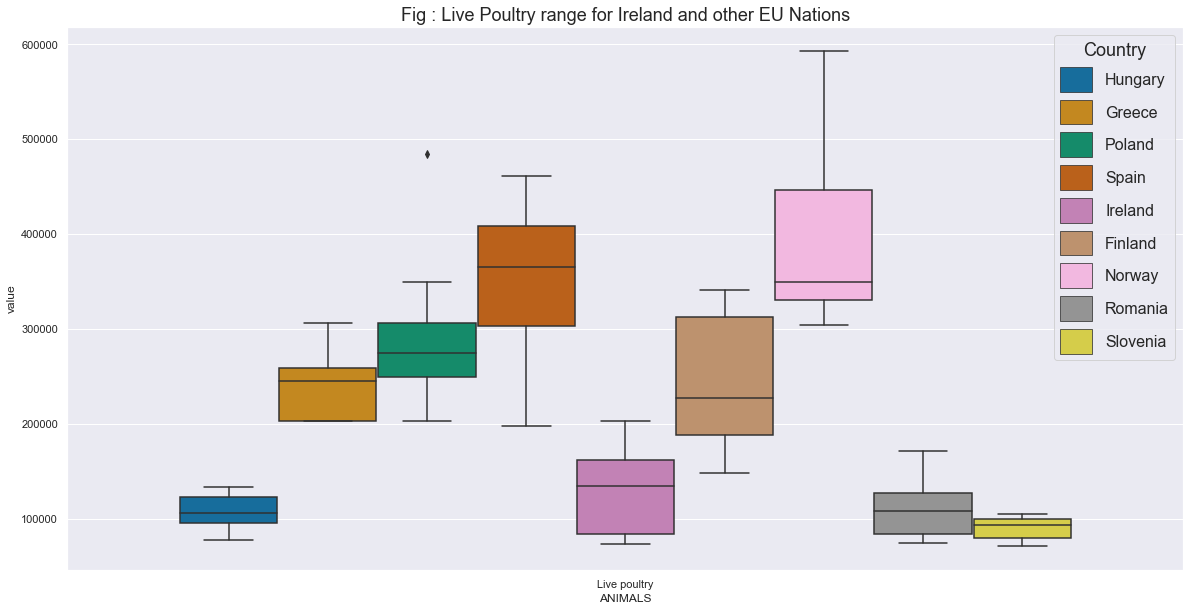

In [42]:
# Let us plot the libvepoultry for each country in a boxplot, taking a range of values proximate to Ireland count

dflseulivepoulp=dflspivotyearwise[ (dflspivotyearwise['ANIMALS']=='Live poultry') & (dflspivotyearwise['value']>70000) & (dflspivotyearwise['value']<600000) ].reset_index()
plt.figure(figsize=(20,10))
sns.set(style="darkgrid") # made use of seaborn library style
sns.boxplot(x = 'ANIMALS', y ='value',hue='COUNTRY' ,data=dflseulivepoulp, palette="colorblind") # note the usage of color pallete as colorblind
plt.title('Fig : Live Poultry range for Ireland and other EU Nations', fontsize=18)
plt.legend(title='Country', fontsize='16', title_fontsize='18',handleheight =2)
plt.show()

Text(0.5, 1.0, 'Fig : Live Poultry range for Ireland')

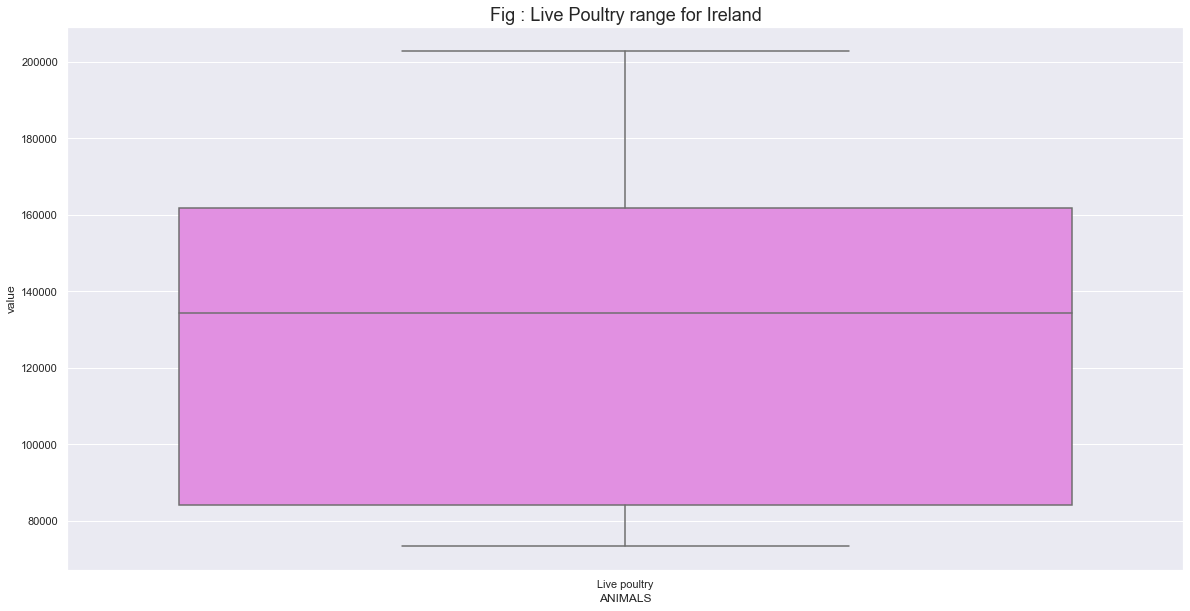

In [43]:
#Plot the EDA for Ireland in a box plot

dflsirllivepoulp=dflspivotyearwise[(dflspivotyearwise['COUNTRY']=='Ireland') & (dflspivotyearwise['ANIMALS']=='Live poultry')].reset_index()

plt.figure(figsize=(20,10))
sns.boxplot(x = 'ANIMALS', y ='value', data=dflsirllivepoulp,color='violet')
plt.title('Fig : Live Poultry range for Ireland', fontsize=18)

In [44]:
dflsirllivepoulp[['value']].describe()

value
count       9.000000
mean   132585.777778
std     47984.051222
min     73451.000000
25%     84084.000000
50%    134221.000000
75%    161816.000000
max    202748.000000

# Inferential Statistics

Let us find the confidence interval of Live Poultry  across 2012 through 2019

In [45]:
#Creating the Livepoultry dataframe for Ireland
dflsirllp=dflsirlagg.loc[dflsirlagg['ANIMALS']=='Live poultry'].reset_index()
dflsirllp=pd.DataFrame(dflsirllp)
dflsirllp.columns = ['level_0','ANIMALS','index','2012','2013','2014','2015','2016','2017','2018','2019','2020']

In [46]:
print(dflsirllp.columns.tolist())

['level_0', 'ANIMALS', 'index', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']


In [47]:
dflsirllp.drop(['level_0','index','ANIMALS'],axis=1,inplace=True)

In [48]:
# create 90% confidence interval, use the scipy.stats
st.t.interval(alpha=0.90, 
              df=9, # Dataframe length
              loc=132585, # mean average for Live Poultry from 2012 - 2020 
              scale = 4
              )

(132577.66754826938, 132592.33245173062)

In [49]:
# create 95% confidence interval
st.t.interval(alpha=0.95, #CI
              df=9, # Dataframe length
              loc=132585, # mean average for Live Poultry from 2012 - 2020 
              scale = 4
              )

(132575.95137134905, 132594.04862865095)

In [50]:
# create 99% confidence interval
st.t.interval(alpha=0.99, 
              df=9, # Dataframe length 
              loc=132585, # mean average for Live Poultry from 2012 - 2020 
              scale = 4
              )

(132572.00065782393, 132597.99934217607)

# T-Test one population 
As we see from the above for the data(sample) from 2012-2020, the average Live Poultry count is 132585. As we see from the above dataset the counts are increasing year after year, testing if the average value for the population is 200000.

In [51]:
X=dflsirllivepoulp['value']
X

0     84084.0
1     84084.0
2     73451.0
3    109602.0
4    134221.0
5    150890.0
6    161816.0
7    192376.0
8    202748.0
Name: value, dtype: float64

In [52]:
#H0 : u = 200000
#H1 : u > 200000D
#stats.ttest_1samp(X,mu of H0)
st.ttest_1samp(X,200000)

Ttest_1sampResult(statistic=-4.2147893209381655, pvalue=0.0029366172201480477)

Hypothesis is rejected because the p value is less than 0.05. Checking if the value is greater than 200000

In [53]:
#H1 : u > 200000
st.t.sf(-4.2147893209381655, 8)

0.998531691389926

Based on the above test we can say that the average mean for Live Poultry population is over 200000.

# T-Test two populations

Case 1: Let us now compare Live Poultry with Live Bovine Animals

In [54]:
#Taking dataset for Live Bovine Animals
dflsirlbrp=dflspivotyearwise[(dflspivotyearwise['COUNTRY']=='Ireland') & (dflspivotyearwise['ANIMALS']=='Broilers')].reset_index()
dflsirlbrp       

index  COUNTRY  YEAR   ANIMALS    value
0    628  Ireland  2012  Broilers  15552.0
1    663  Ireland  2013  Broilers  15552.0
2    710  Ireland  2014  Broilers  15552.0
3    736  Ireland  2015  Broilers   8706.0
4    762  Ireland  2016  Broilers   8706.0
5    803  Ireland  2017  Broilers  22281.0
6    830  Ireland  2018  Broilers  22281.0
7    882  Ireland  2019  Broilers  27496.0
8    885  Ireland  2020  Broilers  32906.0

In [55]:
#We perform the test assuming as H0 that mu1 = mu2 (Live Poultry count = Broiler count)
test = st.ttest_ind(dflsirllivepoulp['value'], dflsirlbrp['value'], 
                      equal_var=True)

display(test)

Ttest_indResult(statistic=7.014147743005124, pvalue=2.922523785071985e-06)

The above tests show that we can reject the hypothesis Live Poultry count = Broiler count

Case 2: Let us compare Live Poultry count of Ireland with some other country

From above can see that based on 2020 data Ireland and Romania are comparable for Live Poultry.
Using T-Test for two populations to see if they are similiar based on the sample data we have from 2012-2020

In [56]:
#Creating dataframe for livestock of Romania
dflsromlivepoulp=dflspivotyearwise[(dflspivotyearwise['COUNTRY']=='Romania') & (dflspivotyearwise['ANIMALS']=='Live poultry')].reset_index()
dflsromlivepoulp  

index  COUNTRY  YEAR       ANIMALS     value
0   3377  Romania  2012  Live poultry   60121.0
1   3411  Romania  2013  Live poultry   74220.0
2   3452  Romania  2014  Live poultry   57797.0
3   3468  Romania  2015  Live poultry  107639.0
4   3528  Romania  2016  Live poultry   63254.0
5   3550  Romania  2017  Live poultry   63254.0
6   3594  Romania  2018  Live poultry   83859.0
7   3628  Romania  2019  Live poultry  126875.0
8   3650  Romania  2020  Live poultry  171391.0

In [57]:
#We perform the test assuming as H0 that mu1 = mu2 (Live Poultry count for Ireland = Live Poultry count for Anabel)
test = st.ttest_ind(dflsirllivepoulp['value'], dflsromlivepoulp['value'], 
                      equal_var=False)

display(test)

Ttest_indResult(statistic=2.0823947729244314, pvalue=0.054482224143036426)

Above test since p value is above 0.05(95% Confidence) , we can say that Live Poultry count for Ireland and Romania are equal.

# ANOVA Test

Let us compare the mean for Live Poultry using the sample data from 2012-2019, between Ireland-Romania-Greece-Hungary.

In [58]:
#Creating datasets for live poultry of Greece and Hungary
dflsgrlivepoulp=dflspivotyearwise[(dflspivotyearwise['COUNTRY']=='Greece') & (dflspivotyearwise['ANIMALS']=='Live poultry')].reset_index()
dflshylivepoulp=dflspivotyearwise[(dflspivotyearwise['COUNTRY']=='Hungary') & (dflspivotyearwise['ANIMALS']=='Live poultry')].reset_index()


dflsirllivepoulp - Live Poultry population for Ireland ;                                                                   
dflsromlivepoulp - Live Poultry population for Romania ;                                                                   
dflsgrlivepoulp - Live Poultry population for Greece ;                                                                     
dflshylivepoulp - Live Poultry population for Hungary

In [59]:
 #Combining the livestock data for the four countries to a single dataframe
dfcomb=dflsirllivepoulp.append(dflsromlivepoulp).append(dflsgrlivepoulp).append(dflshylivepoulp).reset_index()
dfcomb['value']=dfcomb['value'].astype(int)
dfcomb=dfcomb[['COUNTRY','YEAR','ANIMALS','value']]
dfcomb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   COUNTRY  36 non-null     object
 1   YEAR     36 non-null     object
 2   ANIMALS  36 non-null     object
 3   value    36 non-null     int32 
dtypes: int32(1), object(3)
memory usage: 1.1+ KB


<Figure size 1008x720 with 0 Axes>

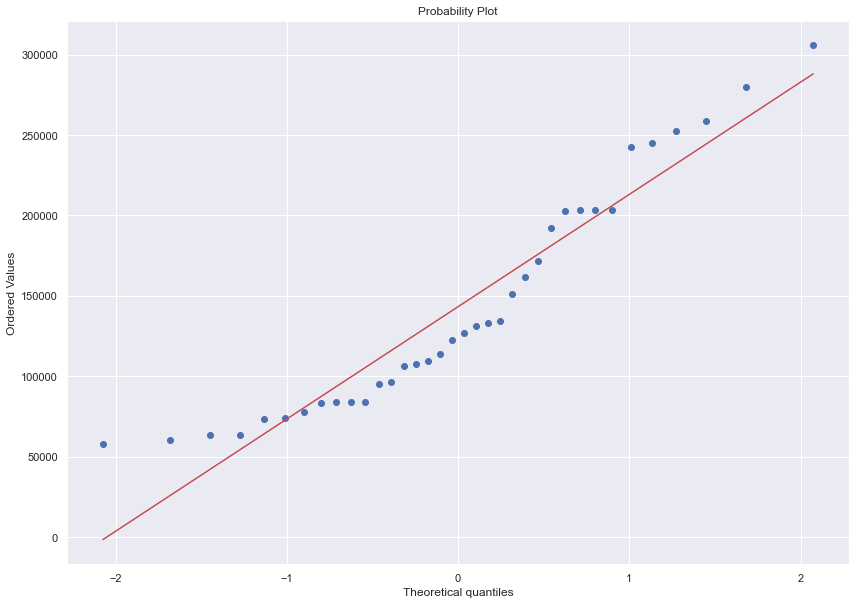

<Figure size 1008x720 with 0 Axes>

In [60]:
#Normality plot. Our variable is "charges"

st.probplot(dfcomb.value, plot=plt)
plt.figure()


In [61]:
#Shapiro wilk test for Ireland

st.shapiro(dfcomb.value[dfcomb.COUNTRY == "Ireland"])

ShapiroResult(statistic=0.9254190325737, pvalue=0.43898195028305054)

In [62]:
#Shapiro wilk test for Romania

st.shapiro(dfcomb.value[dfcomb.COUNTRY == "Romania"])

ShapiroResult(statistic=0.825196385383606, pvalue=0.03943577781319618)

In [63]:
#Shapiro wilk test for Greece

st.shapiro(dfcomb.value[dfcomb.COUNTRY == "Greece"])

ShapiroResult(statistic=0.909574568271637, pvalue=0.31290915608406067)

In [64]:
#Shapiro wilk test for Hungary

st.shapiro(dfcomb.value[dfcomb.COUNTRY == "Hungary"])

ShapiroResult(statistic=0.9456537365913391, pvalue=0.6425020098686218)

In [65]:
#Homogeinity of variance: Levene's test

from scipy.stats import levene

levene(dflsirllivepoulp['value'],dflsromlivepoulp['value'],dflsgrlivepoulp['value'],dflshylivepoulp['value'], center='mean')

LeveneResult(statistic=2.1617846996076224, pvalue=0.11185325781587996)

In [66]:
dfcomb.shape

(36, 4)

In [67]:
#ONE-WAY ANOVA
#H0 : Variances of Mean value for the four countries are same
#H1 : Variances of Mean value for the four countries are different

model = ols('value~COUNTRY', data = dfcomb).fit()
aov = sm.stats.anova_lm(model, type=2)
print(aov)

            df        sum_sq       mean_sq          F        PR(>F)
COUNTRY    3.0  1.295940e+11  4.319800e+10  31.424259  1.166121e-09
Residual  32.0  4.398945e+10  1.374670e+09        NaN           NaN


In [68]:
#ANOVA TWO WAYS
#H0 : Variances of Mean value for the four countries and the years are same
#H1 : Variances of Mean value for the four countries and the years are different
  
model2 = ols('value~COUNTRY+YEAR', data = dfcomb).fit()
aov2 = sm.stats.anova_lm(model2, type=2)
print(aov2)

            df        sum_sq       mean_sq          F        PR(>F)
COUNTRY    3.0  1.295940e+11  4.319800e+10  58.597651  3.430038e-11
YEAR       8.0  2.629673e+10  3.287091e+09   4.458906  2.039520e-03
Residual  24.0  1.769272e+10  7.371968e+08        NaN           NaN


In [69]:
#dflsirllivepoulp.append(dflsromlivepoulp).append(dflsgrlivepoulp).append(dflshylivepoulp)

# Kruskal Wallis Test

We will now do a non- parametric test for the different populations that we tested above (parametric).

dflsirllivepoulp - Live Poultry population for Ireland
dflsromlivepoulp - Live Poultry population for Romania
dflsgrlivepoulp  - Live Poultry population for Greece
dflshylivepoulp  - Live Poultry population for Hungary

In [70]:
# Conduct the Kruskal-Wallis Test
#H0 : Median values for the countries Ireland,Romania,Greece, Hungary are the same.
#H1 : Median values for the countries Ireland,Romania,Greece, Hungary are differnt.

result = st.kruskal(dflsirllivepoulp['value'].sort_values(), dflsromlivepoulp['value'].sort_values(), dflsgrlivepoulp['value'].sort_values(),dflshylivepoulp['value'].sort_values())

#print the result
print(result)

KruskalResult(statistic=22.947650123075157, pvalue=4.141044596936895e-05)


We see after doing Kruskal Wallis test on the populations , statsitic is 22.94 and the pvalue is very small(<0.05), this means at 95% significance, we donot have enough evidence to suggest that the median value for live popultry populations in Ireland, Romania, Greece, Hungary are the same. Hence we reject the hypothesis stating they are all different.

# U-Mann Whitman test

We will perform U-Mann Whitman test on two population Ireland and Romania

In [71]:
from scipy.stats import mannwhitneyu

#H0 : Median values for the countries Ireland and Romania are the same.
#H1 : Median values for the countries Ireland and Romania are differnt.



# Carrying out the Wilcoxon–Mann–Whitney test
results = mannwhitneyu(dflsirllivepoulp['value'].sort_values(), dflsromlivepoulp['value'].sort_values())
results

MannwhitneyuResult(statistic=65.0, pvalue=0.03388460606679897)

We see after doing U-Mann Whitman test on the populations for Ireland and Romania , statsitic is 65.0 and the pvalue is 0.033(<0.05), this means at 95% significance, we donot have enough evidence to suggest that the median value for live popultry populations in Ireland and Romania are the same. Hence we reject the hypothesis stating they are  different.

Doing a U-Mann Whitman test for Ireland between Live Poultry and Broilers.

In [72]:
#import the library mannwhitneyu
from scipy.stats import mannwhitneyu

#H0 : Median values for the Live Poultry and Broilers for Ireland  are the same.
#H1 : Median values for the Live Poultry and Broilers for Ireland  are different.



# Carrying out the Wilcoxon–Mann–Whitney test
results = mannwhitneyu(dflsirllivepoulp['value'].sort_values(), dflsirlbrp['value'].sort_values())
results

MannwhitneyuResult(statistic=81.0, pvalue=0.0003927417716945404)

We see after doing U-Mann Whitman test on Live poultry and Broiler for Ireland , statsitic is 81.0 and the pvalue is 0.0003(<0.05), this means at 95% significance, we donot have enough evidence to suggest that the median value for live popultry populations in Ireland and broiler are the same. Hence we reject the hypothesis stating they are different.

# Machine Learning

Using the dataframe dflspivotyearwise for applying ML models, the values are discrete and hence we will use regression models.
See below, the dataframe contains , year wise counts for each country and each Live stock available in the model. 
Data clean up is done in the steps above, UK is removed from the dataset since it is no longer in the EU.

Machine Learning models accuracy is tested every run, datasets are reorganised to get the correct the accuracy

# NOTE :
####The initial dataset yielded very low accuracy, iterated a different dataset and managed to get better accuracy further down####

In [73]:
#Import Libraries for ML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [74]:
# First iteration, tried to use get_dummies function
X = pd.get_dummies(data=dflspivotyearwise[['COUNTRY','ANIMALS','YEAR']], drop_first=True)

y = dflspivotyearwise ['value']


Linear Regression
--------------------------

Training data Accuracy :  0.2743282386635142
Testing data  Accuracy :  -0.054555688138246516


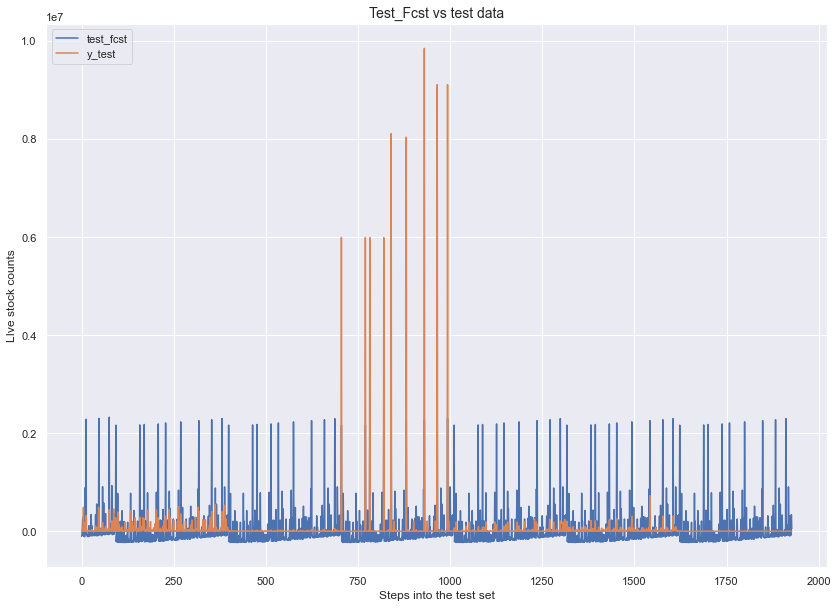

In [75]:


# Split train and test data, 30% test data size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 12345, shuffle = False)



# Fit Linear Regression model
my_lm = LinearRegression()
my_lm.fit(X = X_train, y = y_train)

#Prediction
train_fcst = my_lm.predict(X_train)
test_fcst = my_lm.predict(X_test)

# Store the R2 error into train_r2 and test_r2
train_r2 = r2_score(y_train, train_fcst)
test_r2 = r2_score(y_test, test_fcst)

#Assign variable for plotting later on
lr_train_r2=train_r2
lr_test_r2=test_r2
# Display the training and test score
print("Training data Accuracy : ",train_r2)
print("Testing data  Accuracy : ",test_r2)
# Plot result
plt.plot(list(test_fcst))
plt.plot(list(y_test))
plt.title('Test_Fcst vs test data',fontsize=14)
plt.xlabel('Steps into the test set')
plt.ylabel('LIve stock counts')
plt.legend(['test_fcst', 'y_test'], loc='upper left')

plt.show()

In [76]:
#Prediction based on the linear regression
train_fcst = my_lm.predict(X_train)
test_fcst = my_lm.predict(X_test)
train_fcst,test_fcst

(array([ 122811.50511391, 2164424.6490533 , -211696.47215882, ...,
         -94806.08349871,  318778.84131332, -104287.49703254]),
 array([-103892.94776764,  -67846.81897976,   44023.52192933, ...,
         -53579.13769616,  338907.74816083,   51411.71836445]))

The scores are extremely low, let us apply mapping on the text variables and use it in our predictions

In [77]:
#Creating a list to map the Country names
x=0
mapv=[]
for i in dflspivotyearwise['COUNTRY'].unique():
    mapv.append({i:x})
    x=x+1





In [78]:
#Map the Country names to Integer
mapv= {'Austria': 0,
 'France': 1,
 'Hungary': 2,
 'Greece': 3,
 'Poland': 4,
 'Croatia': 5,
 'Germany (until 1990 former territory of the FRG)': 6,
 'Iceland': 7,
 'Portugal': 8,
 'Spain': 9,
 'Sweden': 10,
 'Romania': 11,
 'Bulgaria': 12,
 'Belgium': 13,
 'Slovenia': 14,
 'Slovakia': 15,
 'Ireland': 16,
 'Serbia': 17,
 'Italy': 18,
 'Finland': 19,
 'Norway': 20,
 'Cyprus': 21,
 'North Macedonia': 22,
 'Netherlands': 23,
 'Montenegro': 24,
 'Malta': 25,
 'Czechia': 26,
 'Luxembourg': 27,
 'Lithuania': 28,
 'Türkiye': 29,
 'Estonia': 30,
 'Latvia': 31,
 'Switzerland': 32,
 'Denmark': 33
 }

dflspivotyearwise['COUNTRYM']=dflspivotyearwise['COUNTRY'].map(mapv)

In [79]:
#Creating a list to map the ANIMALS
x=0
mapva=[]
for i in dflspivotyearwise['ANIMALS'].unique():
    mapva.append({i:x})
    x=x+1
mapva




[{'Bovine animals for slaughter': 0},
 {'Breeding sows, live weight 50 kg or over': 1},
 {'Broilers': 2},
 {'Dairy cows': 3},
 {'Ewes and ewe-lambs, breeding females': 4},
 {'Fattening pigs, live weight 50 kg or over': 5},
 {'Goats, breeding females': 6},
 {'Laying hens': 7},
 {'Live bovine animals': 8},
 {'Live goats': 9},
 {'Live horses': 10},
 {'Live poultry': 11},
 {'Live poultry excluding laying hens and broilers': 12},
 {'Live sheep': 13},
 {'Live swine, domestic species': 14},
 {'Other bovine animals': 15},
 {'Other goats': 16},
 {'Other live animals': 17},
 {'Other pigs': 18},
 {'Other sheep': 19},
 {'Rabbits': 20}]

In [80]:
mapa={'Bovine animals for slaughter': 0,
 'Breeding sows, live weight 50 kg or over': 1,
 'Broilers': 2,
 'Dairy cows': 3,
 'Ewes and ewe-lambs, breeding females': 4,
 'Fattening pigs, live weight 50 kg or over': 5,
 'Goats, breeding females': 6,
 'Laying hens': 7,
 'Live bovine animals': 8,
 'Live goats': 9,
 'Live horses': 10,
 'Live poultry': 11,
 'Live poultry excluding laying hens and broilers': 12,
 'Live sheep': 13,
 'Live swine, domestic species': 14,
 'Other bovine animals': 15,
 'Other goats': 16,
 'Other live animals': 17,
 'Other pigs': 18,
 'Other sheep': 19,
 'Rabbits': 20}

dflspivotyearwise['ANIMALSM']=dflspivotyearwise['ANIMALS'].map(mapa)

In [81]:
dflspivotyearwise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6426 entries, 0 to 6425
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   COUNTRY   6426 non-null   object 
 1   YEAR      6426 non-null   object 
 2   ANIMALS   6426 non-null   object 
 3   value     6426 non-null   float64
 4   COUNTRYM  6426 non-null   int64  
 5   ANIMALSM  6426 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 301.3+ KB


In [82]:
dflspivotyearwise['YEAR']=dflspivotyearwise['YEAR'].astype(int)


<AxesSubplot:title={'center':'Corelation Matrix between Variables'}>

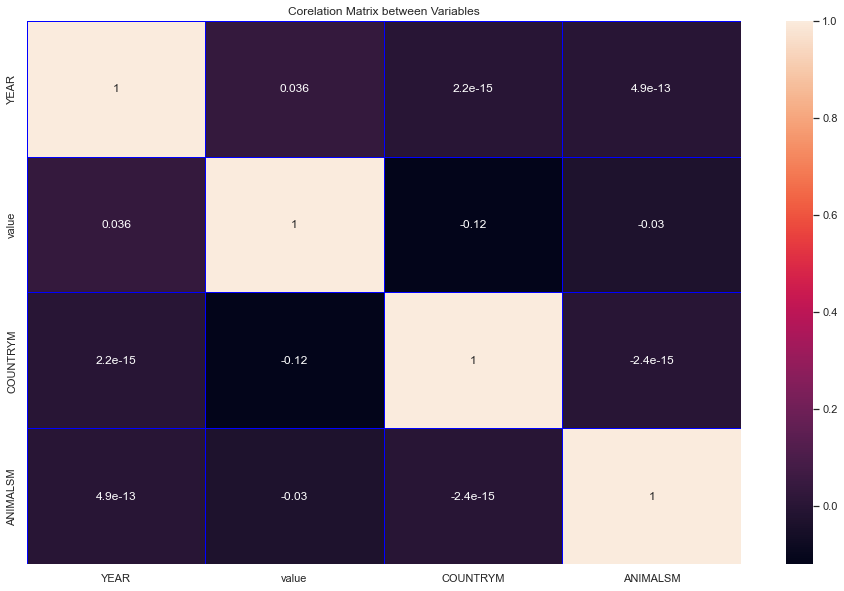

In [83]:
#Plot the co-relation matrix
correlation = dflspivotyearwise.corr()
plt.figure(figsize=(16,10))
plt.title('Corelation Matrix between Variables')
sns.heatmap(correlation,annot=True,linecolor="blue",lw=0.5)

Training data Accuracy :  0.02070874075569784
Testing data  Accuracy :  -0.32015105950938505


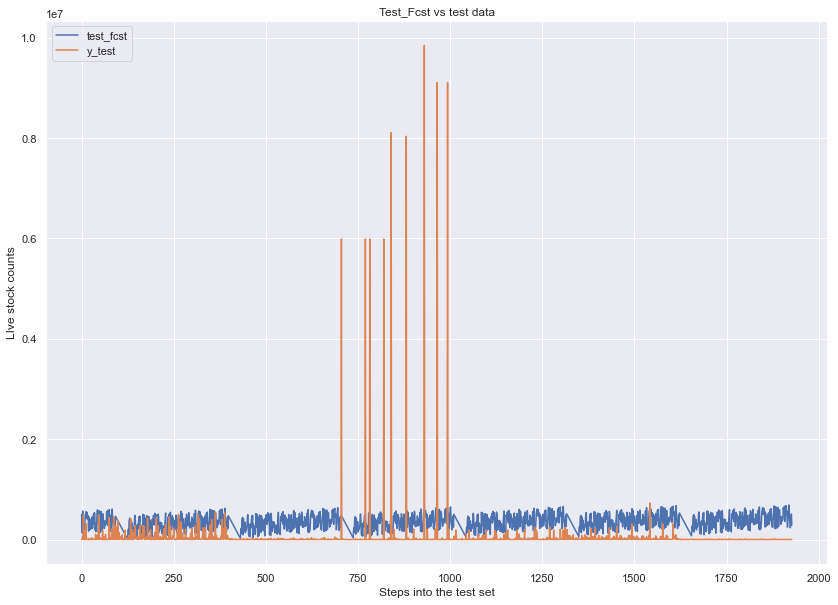

In [84]:
# Now applying linear regression:


X= dflspivotyearwise[['COUNTRYM','ANIMALSM','YEAR']]
y=dflspivotyearwise['value']
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 12345, shuffle = False)


# #Feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.fit_transform(X_test)

# Fit model
my_lm = LinearRegression()
my_lm.fit(X = X_train, y = y_train)

train_fcst = my_lm.predict(X_train)
test_fcst = my_lm.predict(X_test)

# Store the R2 error into train_r2 and test_r2
train_r2 = r2_score(y_train, train_fcst)
test_r2 = r2_score(y_test, test_fcst)

lr_train_r2=train_r2
lr_test_r2=test_r2
# Display the training and test score
print("Training data Accuracy : ",train_r2)
print("Testing data  Accuracy : ",test_r2)
# Plot result
plt.plot(list(test_fcst))
plt.plot(list(y_test))
plt.title('Test_Fcst vs test data')
plt.xlabel('Steps into the test set')
plt.ylabel('LIve stock counts')
plt.legend(['test_fcst', 'y_test'], loc='upper left')

plt.show()

There is no imporvement seen in the above in fact it has worsened by manual mapping, will need to try other models

# Grid Search Cross-Validation

In [85]:
#Import Libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE 

In [86]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 9))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)    

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8]}],
             return_train_score=True, scoring='r2', verbose=1)

In [87]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results[['rank_test_score','param_n_features_to_select','mean_train_score','mean_test_score']]

#Store the average scores in a variable for comparisions
lm_cv_train=cv_results['mean_train_score'].mean()
lm_cv_test=cv_results['mean_test_score'].mean()
print(lm_cv_train,lm_cv_test)

0.017499769088110302 0.01576188320512672


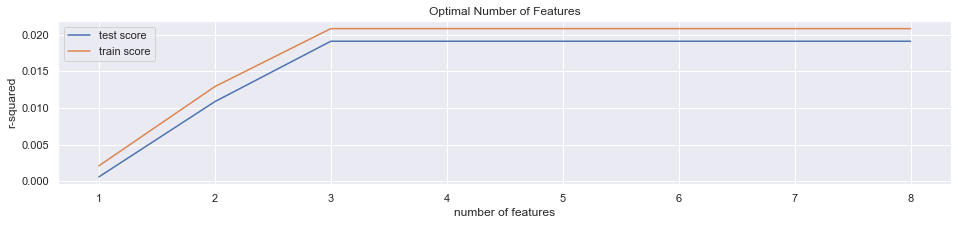

In [88]:
# plotting cv results
plt.figure(figsize=(16,3))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [89]:
#From the above heat map we donot find any reliable variables, creating new set of variables which stores the value in the previous row.
dflspivotyearwise['value_l1'] = dflspivotyearwise ['value'].shift(1)
dflspivotyearwise['value_l2'] = dflspivotyearwise ['value'].shift(2)
dflspivotyearwise['value_l3'] = dflspivotyearwise ['value'].shift(3)
dflspivotyearwise['value_l4'] = dflspivotyearwise ['value'].shift(4)
dflspivotyearwise['value_l5'] = dflspivotyearwise ['value'].shift(5)

# Display the first 10 records
dflspivotyearwise.head()

COUNTRY  YEAR                       ANIMALS     value  COUNTRYM  ANIMALSM  \
0  Austria  2012  Bovine animals for slaughter    4397.0         0         0   
1   France  2012  Bovine animals for slaughter  117694.0         1         0   
2  Hungary  2012  Bovine animals for slaughter   15228.0         2         0   
3   Greece  2012  Bovine animals for slaughter   18216.0         3         0   
4   Poland  2012  Bovine animals for slaughter   25589.0         4         0   

   value_l1  value_l2  value_l3  value_l4  value_l5  
0       NaN       NaN       NaN       NaN       NaN  
1    4397.0       NaN       NaN       NaN       NaN  
2  117694.0    4397.0       NaN       NaN       NaN  
3   15228.0  117694.0    4397.0       NaN       NaN  
4   18216.0   15228.0  117694.0    4397.0       NaN

In [90]:
dflspivotyearwise=dflspivotyearwise.dropna()

<AxesSubplot:>

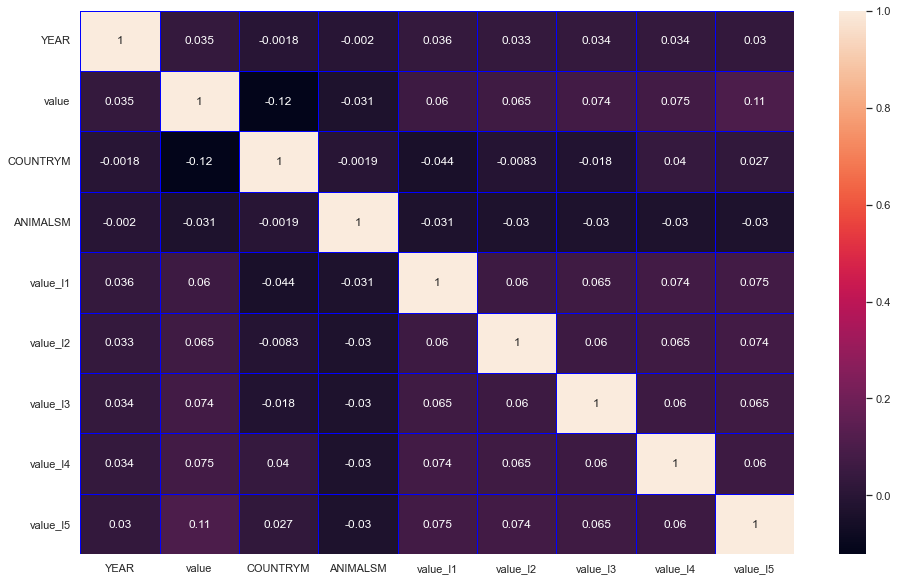

In [91]:
correlation = dflspivotyearwise.corr()
plt.figure(figsize=(16,10))
sns.heatmap(correlation,annot=True,linecolor="blue",lw=0.5)

In [92]:
# Create X and y objects
X = dflspivotyearwise[['YEAR','COUNTRYM','ANIMALSM','value_l1','value_l2','value_l3','value_l4','value_l5'  ]].values
y = dflspivotyearwise['value'].values

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 12345, shuffle = False)


In [93]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 9))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)    

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8]}],
             return_train_score=True, scoring='r2', verbose=1)

In [94]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results[['rank_test_score','param_n_features_to_select','mean_train_score','mean_test_score']]

#Store the average scores in a variable for comparisions
lm_cv_train=cv_results['mean_train_score'].mean()
lm_cv_test=cv_results['mean_test_score'].mean()
print(lm_cv_train,lm_cv_test)

0.028720134744946977 0.023513563672823333


Even now the scores are very less

In [95]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 9))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  
 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8]}],
             return_train_score=True, scoring='r2', verbose=1)

####################################################################################################################

All the above models showed very poor results, using a different dataset with detail of counts for every year.Let us consider year 2012-2019 as independent variable and the year 2020 as dependent target variable.
#####################################################################################################################


# Updated Dataset for better ML model accuracy
# NOTE : 

The below Iteration gives better accuracy and scores


In [96]:
# Taking another data set : dflspivotfinal

dflspivotfinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   COUNTRY  714 non-null    object 
 1   ANIMALS  714 non-null    object 
 2   2012     714 non-null    float64
 3   2013     714 non-null    float64
 4   2014     714 non-null    float64
 5   2015     714 non-null    float64
 6   2016     714 non-null    float64
 7   2017     714 non-null    float64
 8   2018     714 non-null    float64
 9   2019     714 non-null    float64
 10  2020     714 non-null    float64
dtypes: float64(9), object(2)
memory usage: 61.5+ KB


In [97]:
# Change datatype of variables to integer since we cannot have decimal counts for livestock numbers
dflspivotfinal['2012']=dflspivotfinal['2012'].astype(int)
dflspivotfinal['2013']=dflspivotfinal['2013'].astype(int)
dflspivotfinal['2014']=dflspivotfinal['2014'].astype(int)
dflspivotfinal['2015']=dflspivotfinal['2015'].astype(int)
dflspivotfinal['2016']=dflspivotfinal['2016'].astype(int)
dflspivotfinal['2017']=dflspivotfinal['2017'].astype(int)
dflspivotfinal['2018']=dflspivotfinal['2018'].astype(int)
dflspivotfinal['2019']=dflspivotfinal['2019'].astype(int)
dflspivotfinal['2020']=dflspivotfinal['2020'].astype(int)


Here let us consider Country, Animals, values from 2012-2019 as the independent variables, 2020 values as target.

Mapping the string values to integers

In [98]:
dflspivotfinal['COUNTRYM']=dflspivotfinal['COUNTRY'].map(mapv) #mapv is already obtained in a step above
dflspivotfinal['ANIMALSM']=dflspivotfinal['ANIMALS'].map(mapa) #mapv is already obtained in a step above

In [99]:
dflspivotfinal

COUNTRY                                   ANIMALS    2012    2013  \
0    Austria              Bovine animals for slaughter    4397    4397   
1    Austria  Breeding sows, live weight 50 kg or over    4370    3579   
2    Austria                                  Broilers  339089  339089   
3    Austria                                Dairy cows   94591   95873   
4    Austria      Ewes and ewe-lambs, breeding females   61346   61346   
..       ...                                       ...     ...     ...   
709  Türkiye                               Other goats     155     155   
710  Türkiye                        Other live animals       0       0   
711  Türkiye                                Other pigs       0       0   
712  Türkiye                               Other sheep    3180    3180   
713  Türkiye                                   Rabbits       0       0   

       2014    2015    2016     2017     2018     2019     2020  COUNTRYM  \
0      4397   25773   32988    20524    21071    22085    22041         0   
1      5444    5743    5020     6055     6249     7255     7709         0   
2    457868  597579  980699  1132177  1248722  1390986  1533377         0   
3     96829   95361  106735   115080   115424   115371   116441         0   
4     48495   51799   59066    60106    63118    64133    62984         0   
..      ...     ...     ...      ...      ...      ...      ...       ...   
709     138    1300      30       89      188      188      188        29   
710       0       0       0        0        0        0        0        29   
711       0       0       0        0        0        0        0        29   
712     281     822     502       29      284      284      284        29   
713       0       0       0        0        0        0        0        29   

     ANIMALSM  
0           0  
1           1  
2           2  
3           3  
4           4  
..        ...  
709        16  
710        17  
711        18  
712        19  
713        20  

[714 rows x 13 columns]

<AxesSubplot:title={'center':'Fig : Co-relation between variables'}>

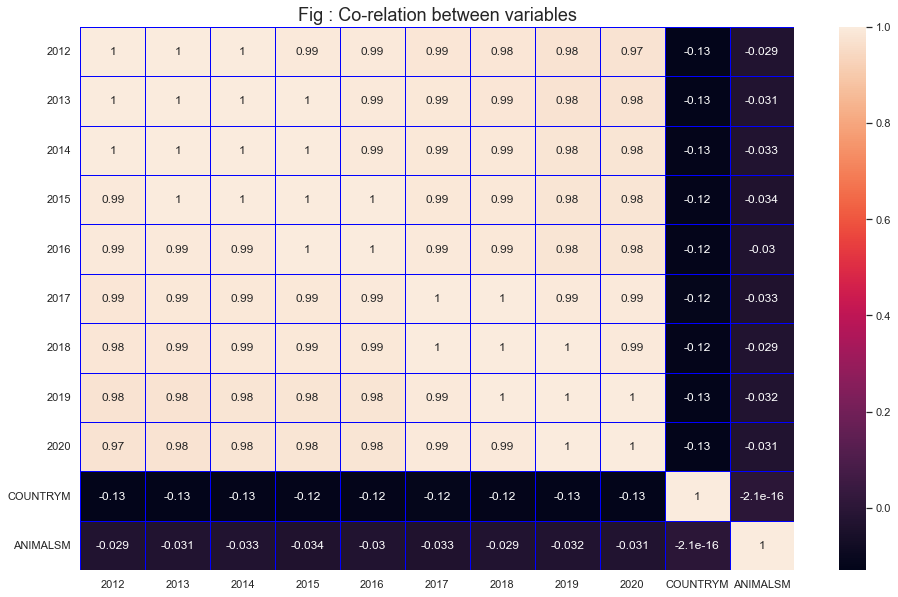

In [100]:
#Corelation Matrx between the variables using heatmap
correlation = dflspivotfinal.corr()
plt.figure(figsize=(16,10))
plt.title('Fig : Co-relation between variables', fontsize=18)
sns.heatmap(correlation,annot=True,linecolor="blue",lw=0.5)

Above heat map shows higher corelation between variables

In [101]:
# Create X and y objects
X = dflspivotfinal[['COUNTRYM','ANIMALSM','2012','2013','2014','2015','2016','2017','2018','2019']].values
y = dflspivotfinal['2020'].values

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 12345, shuffle = False)


Training data Accuracy :  0.9960131024165418
Testing data  Accuracy :  0.9488067773772474


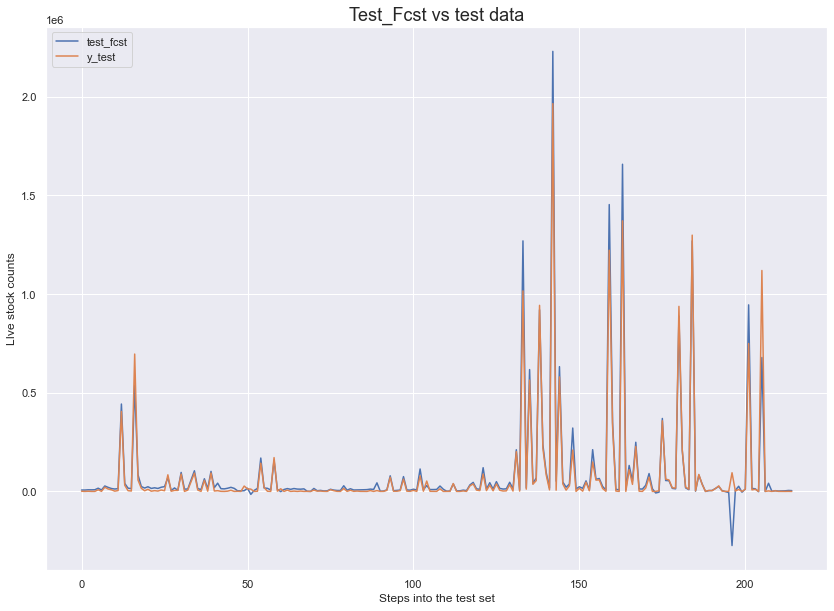

In [102]:
#Applying Linear Regression :

# Fit model
my_lm = LinearRegression()
my_lm.fit(X = X_train, y = y_train)

train_fcst = my_lm.predict(X_train)
test_fcst = my_lm.predict(X_test)

# Store the R2 error into train_r2 and test_r2
train_r2 = r2_score(y_train, train_fcst)
test_r2 = r2_score(y_test, test_fcst)

lr_train_r2=train_r2
lr_test_r2=test_r2
# Display the training and test score
print("Training data Accuracy : ",train_r2)
print("Testing data  Accuracy : ",test_r2)

# Plot result
plt.plot(list(test_fcst))
plt.plot(list(y_test))
plt.title('Test_Fcst vs test data',fontsize=18)
plt.xlabel('Steps into the test set')
plt.ylabel('LIve stock counts')
plt.legend(['test_fcst', 'y_test'], loc='upper left')

plt.show()

##### Above analysis shows that, we get 99% training accuracy and  94% test accuracy

In [103]:
train_fcst = my_lm.predict(X_train)
test_fcst = my_lm.predict(X_test)
train_fcst,test_fcst

(array([ 4.53486818e+04,  1.51654527e+04,  1.65706309e+06,  1.31996896e+05,
         8.49682116e+04,  3.87193669e+04,  4.58476865e+04,  1.12499791e+06,
         4.62968706e+05,  6.79211960e+04,  3.38836173e+04,  3.32188168e+06,
         6.14512766e+05,  1.46582827e+05,  8.85075966e+04,  3.06067565e+05,
         3.75217241e+04,  2.78083725e+04,  5.20513038e+04,  7.88185193e+04,
         2.14906596e+04,  7.09689771e+03,  3.20619563e+03,  3.90811504e+06,
         2.71358285e+04,  1.98741566e+04,  1.92643597e+04,  1.09674917e+04,
         9.12972951e+05,  1.21609803e+05,  1.43808503e+04,  8.36622020e+03,
         4.84529651e+06,  6.93561318e+04,  3.91132296e+04,  2.72009997e+04,
         9.52349440e+04,  1.26391511e+04,  1.67450163e+04,  1.23328526e+04,
         2.33836169e+04,  1.19755729e+04,  1.01756072e+04,  2.54204740e+03,
         2.93270761e+03,  7.93835953e+03,  3.14625587e+04,  4.59757848e+03,
         1.43891497e+04,  5.72348181e+03,  2.00505108e+04,  1.74008906e+04,
         7.6

# Cross-Validation

 # K-Fold CV

In [104]:
# k-fold CV (using all the  variables)
lm = LinearRegression()
trainscores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
trainscores.mean()

testscores = cross_val_score(lm, X_test, y_test, scoring='r2', cv=5)
trainscores.mean(),testscores.mean()


(0.9682110138511367, 0.9333049083223302)

# GRID Search CV

In [105]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 9))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)  

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8]}],
             return_train_score=True, scoring='r2', verbose=1)

In [106]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results[['rank_test_score','param_n_features_to_select','mean_train_score','mean_test_score']]

#Store the average scores in a variable for comparisions
lm_cv_train=cv_results['mean_train_score'].mean()
lm_cv_test=cv_results['mean_test_score'].mean()
print(lm_cv_train,lm_cv_test)

0.7530086902796982 0.7100692217272782


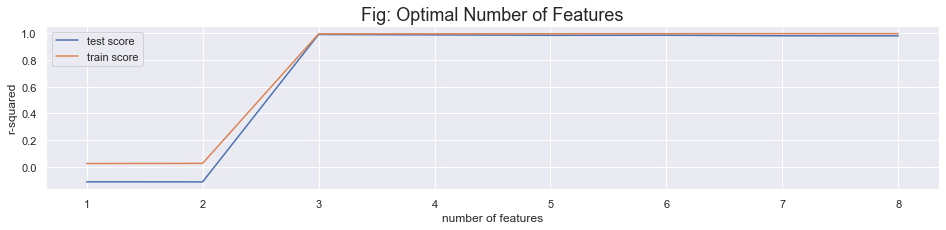

In [107]:
# plotting cv results
plt.figure(figsize=(16,3))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Fig: Optimal Number of Features",fontsize=18)
plt.legend(['test score', 'train score'], loc='upper left')

In [108]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results[['rank_test_score','param_n_features_to_select','mean_train_score','mean_test_score']]

rank_test_score param_n_features_to_select  mean_train_score  \
0                7                          1          0.024220   
1                8                          2          0.025407   
2                1                          3          0.994540   
3                2                          4          0.995139   
4                4                          5          0.995570   
5                3                          6          0.996239   
6                5                          7          0.996405   
7                6                          8          0.996549   

   mean_test_score  
0        -0.112784  
1        -0.113206  
2         0.990206  
3         0.987188  
4         0.984072  
5         0.984669  
6         0.980457  
7         0.979952

# K Neighbour Regressor

In [109]:

#Applying another ML model K Neighbour Regressor

from sklearn.neighbors import KNeighborsRegressor

neighbors=np.arange(1,10)
train_accuracy=np.empty(len(neighbors))
test_accuracy=np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    # Declare and initialise kNN classifier with k neighbors
    kNR = KNeighborsRegressor(n_neighbors = k)
    
    #Call the method fit to train the model
    kNR.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i]=kNR.score(X_train,y_train)
    
    #Compute accuracy on the training set
    test_accuracy[i]=kNR.score(X_test,y_test)
    

knr_train_acc=train_accuracy.mean()
knr_test_acc=test_accuracy.mean()

y_test_pred = kNR.predict(X_test)
y_train_pred = kNR.predict(X_train)

# Display the r2 score values
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

R2_knR_train=r2_score(y_train, y_train_pred)
R2_knR_test=r2_score(y_test,y_test_pred)

print('Accuracy : ',knr_train_acc,knr_test_acc)
print('R2 : ',R2_knR_train,R2_knR_test)

R^2 train: 0.769, test: 0.859
Accuracy :  0.8738837051564995 0.8864133664039824
R2 :  0.7686104194068805 0.8587105623836812


# Random Forest Regressor

In [110]:
# import RandomForestRegressor from sklearn
from sklearn.ensemble import RandomForestRegressor

# Create an object forest by calling a method RandomForestRegressor()
forest = RandomForestRegressor(n_estimators = 1000, 
                               criterion = 'mse', 
                               random_state = 1, 
                               n_jobs = -1)

# Train the Model by calling a fit() method
forest.fit(X_train, y_train)

    #Compute accuracy on the training set
train_accuracy[i]=kNR.score(X_train,y_train)
    
    #Compute accuracy on the training set
test_accuracy[i]=kNR.score(X_test,y_test)

print("Mean Train accuracy : ",train_accuracy.mean() )
print("Mean Test accuracy : ",test_accuracy.mean() )

RF_Train_acc=train_accuracy.mean()
RF_Test_acc=test_accuracy.mean()

# Display the r2 score values
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

R2_RF_train=r2_score(y_train, y_train_pred)
R2_RF_test=r2_score(y_test,y_test_pred)

Mean Train accuracy :  0.8738837051564995
Mean Test accuracy :  0.8864133664039824
R^2 train: 0.769, test: 0.859


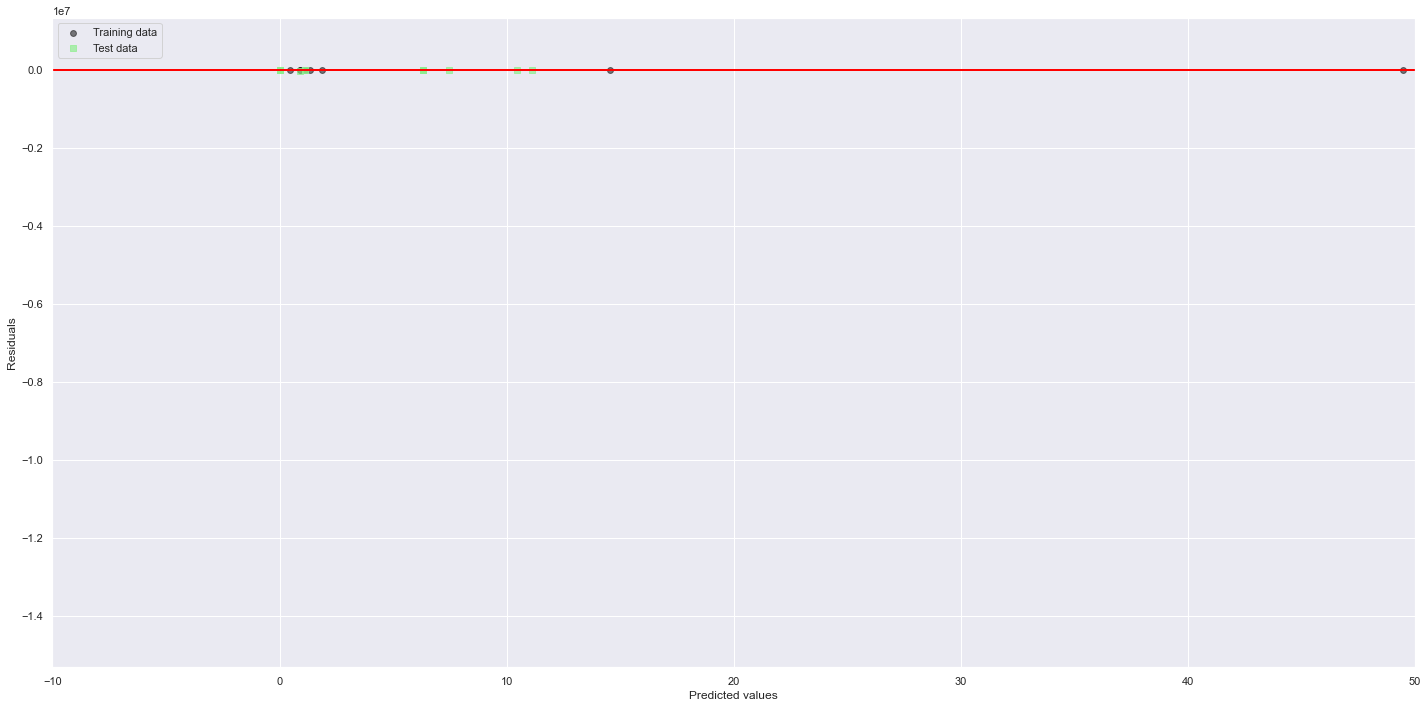

In [111]:
# plotting cv results
plt.figure(figsize=(20,10))

# Draw a scatter plot
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c = 'black', 
            marker = 'o', 
            s = 35,
            alpha = 0.5,
            label = 'Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c = 'lightgreen', 
            marker = 's', 
            s = 35,
            alpha = 0.7,
            label = 'Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2, color = 'red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

# Artificial Neural Network

In [112]:
X_train.shape

(499, 10)

16/16 [==============================] - 0s 3ms/step - loss: 19576842240.0000 - accuracy: 0.0000e+00
Training Accuracy: 0.00%

7/7 [==============================] - 0s 3ms/step - loss: 6543804416.0000 - accuracy: 0.0047
Testing Accuracy: 0.47%



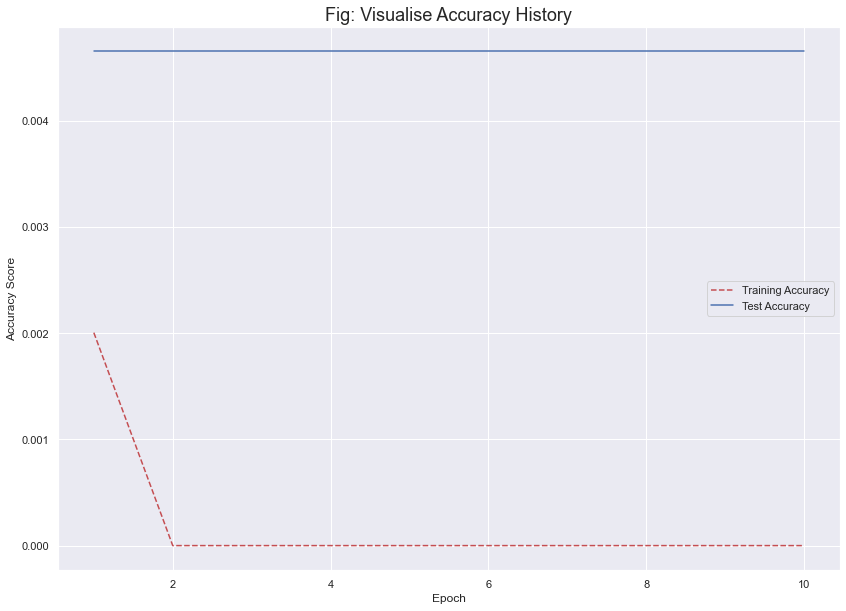

Accuracy :  [0.0020040080416947603, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.004651162773370743, 0.004651162773370743, 0.004651162773370743, 0.004651162773370743, 0.004651162773370743, 0.004651162773370743, 0.004651162773370743, 0.004651162773370743, 0.004651162773370743, 0.004651162773370743]
R2 :  0.9914743951332256 0.8999550819262438


In [113]:
# Load libraries


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE 
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
#from sklearn.datasets import make_regression
#from sklearn.model_selection import train_test_split
#from sklearn import preprocessing


# Start neural network
network = models.Sequential()

# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=32,
                         activation="relu",
                         input_shape=(X_train.shape[1],)))

# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=32, activation="relu"))

# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=20, activation="relu"))




# Add fully connected layer with no activation function
network.add(layers.Dense(units=1))

# Compile neural network
network.compile(loss="mse", # Mean squared error
                optimizer="RMSprop", # Optimization algorithm
                metrics=["accuracy"]) # Accuracy

# Train neural network
history = network.fit(X_train, # Features
                      y_train, # Target vector
                      epochs=10, # Number of epochs
                      verbose=0, # No output
                      batch_size=100, # Number of observations per batch
                      validation_data=(X_test, y_test)) # Test data

# Predict classes of train set
y_train_pred = network.predict(X_train)

# Predict classes of test set
y_test_pred = network.predict(X_test)

scores = network.evaluate(X_train, y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1] * 100))

scores = network.evaluate(X_test, y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1] * 100))


# Get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Get training and test accuracy histories
an_training_accuracy = history.history["accuracy"]
an_test_accuracy = history.history["val_accuracy"]

R2_AN_train=r2_score(y_train, y_train_pred)
R2_AN_test=r2_score(y_test,y_test_pred)

plt.plot(epoch_count, an_training_accuracy, "r--")
plt.plot(epoch_count, an_test_accuracy, "b-")

# Visualize accuracy history
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.title("Fig: Visualise Accuracy History",fontsize=18)

plt.show();

print('Accuracy : ',an_training_accuracy,an_test_accuracy)
print('R2 : ',R2_AN_train,R2_AN_test)

# Summary:

Summarising the ML models here and comparing their accuracy and R2scores

In [114]:
#Creating a dataframe to hold the accuracy and R2 scores
dfconclusion=[]
dfconclusion =pd.DataFrame()
dfconclusion['Model'] = ['Linear Regression','Linear Regression with CV','K Neighbours Regressor','Random Forest Regressor','Artificial Neural Network']
dfconclusion['TrainAccuracy'] = [lr_train_r2,lm_cv_train,knr_train_acc,RF_Train_acc,0.1743]
dfconclusion['TestAccuracy'] = [lr_test_r2,lm_cv_test,knr_test_acc,RF_Test_acc,0.097]
dfconclusion['TrainR2'] = [lr_train_r2,lm_cv_train,R2_knR_train,R2_RF_train,R2_AN_train]
dfconclusion['TestR2'] = [lr_test_r2,lm_cv_test,R2_knR_test,R2_RF_train,R2_AN_test]
dfconclusion

Model  TrainAccuracy  TestAccuracy   TrainR2    TestR2
0          Linear Regression       0.996013      0.948807  0.996013  0.948807
1  Linear Regression with CV       0.753009      0.710069  0.753009  0.710069
2     K Neighbours Regressor       0.873884      0.886413  0.768610  0.858711
3    Random Forest Regressor       0.873884      0.886413  0.768610  0.768610
4  Artificial Neural Network       0.174300      0.097000  0.991474  0.899955

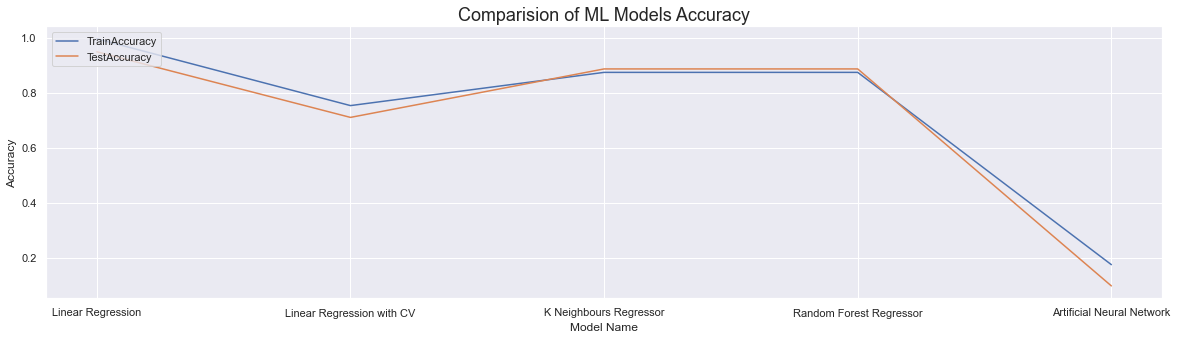

In [115]:
#Draw a line chart, showing average footfall each weekdays

plt.figure(figsize=(20,5))

plt.plot(dfconclusion["Model"], dfconclusion["TrainAccuracy"])
plt.plot(dfconclusion["Model"], dfconclusion["TestAccuracy"])

#creating the title to the plot
plt.title("Comparision of ML Models Accuracy",fontsize=18)

#creating the label along the x-axis
plt.xlabel("Model Name")
#creating labels along the y axis
plt.ylabel("Accuracy")

plt.legend(['TrainAccuracy', 'TestAccuracy'], loc='upper left')

plt.show()

# Sentimental Analysis

Senntimental Analysis is done for the below criteria, Happy (1) if the population in a year is greater than average, Sad(-1) if the population is below 500 counts of the average, neutral if they fall between 0 nd 500 range difference with the average

In [116]:
#Creating a mean dataframe
dflspivotyearwisemean=pd.DataFrame(dflspivotyearwise.groupby(['ANIMALS']).mean()['value'])
#dflspivotyearwisemean
#dflsrawagg=dflsraw.loc[dflsraw['COUNTRY']=='Ireland'].groupby(['ANIMALS']).mean()


In [117]:
#Adding a new field Mean on the dataframe

dflspivotyearwise["MEAN"]=dflspivotyearwise["ANIMALS"].map(dflspivotyearwisemean["value"])

In [118]:
dflspivotyearwise.reset_index()

index                                           COUNTRY  YEAR  \
0         5                                           Croatia  2012   
1         6  Germany (until 1990 former territory of the FRG)  2012   
2         7                                           Iceland  2012   
3         8                                          Portugal  2012   
4         9                                             Spain  2012   
...     ...                                               ...   ...   
6416   6421                                           Denmark  2020   
6417   6422                                           Estonia  2020   
6418   6423                                           Finland  2020   
6419   6424                                           Belgium  2020   
6420   6425                                           Türkiye  2020   

                           ANIMALS     value  COUNTRYM  ANIMALSM  value_l1  \
0     Bovine animals for slaughter    2791.0         5         0   25589.0   
1     Bovine animals for slaughter   59586.0         6         0    2791.0   
2     Bovine animals for slaughter       0.0         7         0   59586.0   
3     Bovine animals for slaughter    8136.0         8         0       0.0   
4     Bovine animals for slaughter  143068.0         9         0    8136.0   
...                            ...       ...       ...       ...       ...   
6416                       Rabbits     646.0        33        20      16.0   
6417                       Rabbits     269.0        30        20     646.0   
6418                       Rabbits       0.0        19        20     269.0   
6419                       Rabbits      55.0        13        20       0.0   
6420                       Rabbits       0.0        29        20      55.0   

      value_l2  value_l3  value_l4  value_l5          MEAN  
0      18216.0   15228.0  117694.0    4397.0  28229.212625  
1      25589.0   18216.0   15228.0  117694.0  28229.212625  
2       2791.0   25589.0   18216.0   15228.0  28229.212625  
3      59586.0    2791.0   25589.0   18216.0  28229.212625  
4          0.0   59586.0    2791.0   25589.0  28229.212625  
...        ...       ...       ...       ...           ...  
6416       0.0       0.0    3221.0       0.0   1036.385621  
6417      16.0       0.0       0.0    3221.0   1036.385621  
6418     646.0      16.0       0.0       0.0   1036.385621  
6419     269.0     646.0      16.0       0.0   1036.385621  
6420       0.0     269.0     646.0      16.0   1036.385621  

[6421 rows x 13 columns]

In [119]:
# Added a new sentiment field by comparing the value for a year to the mean, made use of Lambda function

dflspivotyearwise['sentiment']= dflspivotyearwise.apply(lambda x: 'negative' if x['value']<x['MEAN']-500 else ('positive' if x['value']>x['MEAN'] else 'neutral'), axis=1)

In [120]:
dflspivotyearwise['sentiment'].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

In [121]:
#Analysus usind Multinomial NB
from sklearn.naive_bayes import MultinomialNB

# Instantiate an object model by calling a method MultinomialNB()
model_tdidf = MultinomialNB()

In [122]:
#Defining the X and y variable
X=dflspivotyearwise[['YEAR','COUNTRYM','ANIMALSM','value','value_l1','value_l2','value_l3','value_l4','value_l5']]
y=dflspivotyearwise['sentiment']

In [123]:
# Split the dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Train the model by calling a method fit() of multinomial NB class
model_tdidf.fit(X_train, y_train)

# Call predict() method
y_pred = model_tdidf.predict(X_test)
y_pred

array(['neutral', 'negative', 'negative', ..., 'neutral', 'neutral',
       'negative'], dtype='<U8')

In [124]:
from sklearn.metrics import classification_report

# Instantiate a mthod named as classification_report
cf = classification_report(y_test, y_pred)

# Display the values of an object cf
print(cf)

              precision    recall  f1-score   support

    negative       0.97      0.49      0.65      1494
     neutral       0.02      0.86      0.03        14
    positive       0.79      0.72      0.75       419

    accuracy                           0.54      1927
   macro avg       0.59      0.69      0.48      1927
weighted avg       0.92      0.54      0.67      1927



In [125]:
# Sentiment Analysis using Logistic Regression

from sklearn.linear_model import LogisticRegression
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

np.random.seed(0)
np.set_printoptions(precision=6)

cv5_idx = list(StratifiedKFold(n_splits=5, shuffle=False, random_state=None).split(X, y))
    
cross_val_score(LogisticRegression(random_state=123), X, y, cv=cv5_idx).mean()


0.8562559850661235

In [126]:
# GRID CV

from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(LogisticRegression(), {}, cv=cv5_idx, verbose=3).fit(X, y) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.837 total time=   0.5s
[CV 2/5] END ..................................., score=0.857 total time=   0.4s
[CV 3/5] END ..................................., score=0.875 total time=   0.4s
[CV 4/5] END ..................................., score=0.905 total time=   0.4s
[CV 5/5] END ..................................., score=0.807 total time=   0.4s


In [127]:
cross_val_score(LogisticRegression(), X, y, cv=cv5_idx).mean()

0.8562559850661235

# Interactive dashboard 

We will view the livestock counts across the years for different countries using the interactive chart.

# Visualise Livestock counts across all EU Countries over the years using Year play button

In [128]:
# Set the max and minimum values
ymin,ymax=min(dflspivotyearwise.value),max(dflspivotyearwise.value) 

#plotly.express as px
fig=px.scatter(dflspivotyearwise,
              x='value',
              y='MEAN',
              animation_frame='YEAR',
              animation_group='ANIMALS',
              color='COUNTRY',
              facet_col='COUNTRY',
              width=10000,
              height=400,
              log_x=True,
              size_max=45,
              #range_x=[xmin,xmax],
              range_y=[ymin,ymax])

fig.show()

# Barchart for Live stock Country and animal wise, using interactive selection scroll bar

In [129]:
# Import libraries for visualisation
import ipywidgets as widgets
from ipywidgets import Layout
import matplotlib.pyplot as plt
from folium import plugins

# Define global variables for using in the GUI
global country
global animals

style = {'description_width': 'initial'}

# Get the unique country list
unique_country = dflspivotyearwise.COUNTRY.unique()

# Set up the widgets for selecting the countries
country = widgets.SelectMultiple(
    options = unique_country.tolist(),
    value = ['Ireland', 'Romania'],
    description='Select the Country',
    disabled=False,
    layout = Layout(width='50%', height='80px', display='flex')
)


# Get the unique animal list
unique_animals = dflspivotyearwise.ANIMALS.unique()

style = {'description_width': 'initial'}

# Set up the widgets for selecting the animals

animals = widgets.SelectMultiple(
    options = unique_animals.tolist(),
    value = ['Laying hens', 'Broilers'],
    description='Select Animals',
    disabled=False,
    style=style,
    layout = Layout(width='50%', height='80px')
)


In [130]:
#Define a function to create a bar chart as per the widget selection
def update_bar(country, animals):
    # selected country is stored in a dataframe
    global bar1
    global bar2
    global fig
    #dflspivotyearwise = dflspivotyearwise.iloc[0:limit, :]
    df_country = dflspivotyearwise.loc[dflspivotyearwise['COUNTRY'].isin(np.array(country))]
    df_animals = df_country.loc[df_country['ANIMALS'].isin(np.array(animals))]
    
    
    
    animals_unique = df_animals[['ANIMALS','value']]
    animals_unique = animals_unique.reset_index()
    
    country_unique = df_animals[['COUNTRY','value']]
    country_unique = country_unique.reset_index()

    #Set the figure size
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    plt.title('Interactive Organic Livestock count Dashboard')

    plt.grid(visible=None)
    ax1.bar(animals_unique['ANIMALS'], animals_unique['value'],color = 'orange')
    bar1=ax1.bar(animals_unique['ANIMALS'], animals_unique['value'],color = 'orange')
    

    ax1.set_title('Fig: Live stock counts distributed animal wise',fontsize=18)
    ax2.bar(country_unique['COUNTRY'], country_unique['value'],color = 'blue')
    bar2=ax2.bar(country_unique['COUNTRY'], country_unique['value'],color = 'blue')
    

    ax2.set_title('Fig: Live stock counts distributed country wise',fontsize=18)
    
#     axl = sns.lineplot(data=df_country, x ='YEAR', y = 'value',
#                   hue='ANIMALS', lw=3)
    plt.show()

#Call the interactive widget method, function update_bar is invoked from the object.
widgets.interactive(update_bar, country = country, animals = animals)

interactive(children=(SelectMultiple(description='Select the Country', index=(11, 6), layout=Layout(display='f…

# GUI - Navigate through statistical charts/ML charts/ data summary -Tkinter

Let us now create a GUI to navigate through the above interactive chart, ML model and Statistics charts

In [131]:
#import libraries
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from tkinter import *

# Intatitate a method root from Tkinter class
root= tk.Tk()

#Set the canvas for the UI
canvas1 = tk.Canvas(root, width = 800, height = 500)
canvas1.pack()

# labels to be included in the UI
label1 = tk.Label(root, text='Organic Livestock Counts Analysis')
label1.config(font=('Arial', 20))
canvas1.create_window(400, 50, window=label1)

label2 = tk.Label(root, text='****Make sure you click on clear charts before navigating to any other button****')
label2.config(font=('Arial', 10))
canvas1.create_window(400, 110, window=label2)


# Define a function for Interactive animal count
def anicount_chart():
    global bari1
    #Call the interactive widget method, function update_bar is invoked from the object.
     #fig= widgets.interactive(update_bar, country = country, animals = animals) - This is defined above
    bari1 = FigureCanvasTkAgg(fig, root) #figure is global as defined in interactive widget
    bari1.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=0)

# Define a function for ML Model comparison chart
def ml_model_comparision():
    global line1
    figure = plt.figure(figsize=(20,5)) 
    plt.plot(dfconclusion["Model"], dfconclusion["TrainAccuracy"])
    plt.plot(dfconclusion["Model"], dfconclusion["TestAccuracy"])
    
    #creating the title to the plot
    plt.title("Comparision of ML Models Accuracy",fontsize=18)
    #creating the label along the x-axis
    plt.xlabel("Model Name")
    #creating labels along the y axis
    plt.ylabel("Accuracy")

    plt.legend(['TrainAccuracy', 'TestAccuracy'], loc='upper left')
    #plt.show()
    #Call the interactive widget method, function update_bar is invoked from the object.
    
    line1 = FigureCanvasTkAgg(figure, root)
    line1.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=0)

# Define a function for Stats boxplot
def stat_boxplot_eu():
    global box1
    figureb = plt.figure(figsize=(20,100)) 
    sns.set(style="darkgrid") # made use of seaborn library style
    sns.boxplot(x = 'ANIMALS', y ='value',hue='COUNTRY' ,data=dflseulivepoulp, palette="colorblind") # note the usage of color pallete as colorblind
    plt.title('Fig : Live Poultry range for Ireland and other EU Nations', fontsize=18)
    plt.legend(title='Country', fontsize='16', title_fontsize='18',handleheight =2)
    box1 = FigureCanvasTkAgg(figureb, root)
    box1.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=0)

# Define a function for clearing the stats
def clear_charts():
    bari1.get_tk_widget().pack_forget()
    line1.get_tk_widget().pack_forget()
    box1.get_tk_widget().pack_forget()
    
#Create buttons for the UI navigation,and call the functions defined above
button1 = tk.Button (root, text=' Animal Country counts Chart ',command=anicount_chart, bg='palegreen2', font=('Arial', 11, 'bold')) 
canvas1.create_window(400, 140, window=button1)

button2 = tk.Button (root, text=' Machine Learning Model Comparisions ',command=ml_model_comparision, bg='palegreen2', font=('Arial', 11, 'bold')) 
canvas1.create_window(400, 180, window=button2)

button3 = tk.Button (root, text=' Statistical Box Plot for EU countries ',command=stat_boxplot_eu, bg='palegreen2', font=('Arial', 11, 'bold')) 
canvas1.create_window(400, 220, window=button3)

button4 = tk.Button (root, text='  Clear Charts  ', command=clear_charts, bg='lightskyblue2', font=('Arial', 11, 'bold'))
canvas1.create_window(400, 260, window=button4)

button5= tk.Button (root, text='Exit Application', command=root.destroy, bg='lightsteelblue2', font=('Arial', 11, 'bold'))
canvas1.create_window(400, 300, window=button5)
 
# call the method root instaniated above for getting the UI
root.mainloop()
    


